In [232]:
import pandas as pd
import numpy as np
import os,sys
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')
%matplotlib inline
%precision 4

'%.4f'

In [233]:
df=pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True, dayfirst=True)
df=df.round(decimals=2, out=None)
df

Open    High     Low   Close  Adj Close    Volume
Date                                                           
2012-01-03   58.49   58.93   58.43   58.75      50.77  75555200
2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500
2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400
2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200
2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100
...            ...     ...     ...     ...        ...       ...
2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000
2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700
2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300
2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500
2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600

[2011 rows x 6 columns]

In [30]:
# df.set_index(pd.to_datetime(df.index,format='%d-%m-%Y'),inplace=True)
# df

### Checking to see if there are any missing dates in the data

In [37]:
from collections import Counter

org = pd.date_range(df.index[0], df.index[-1],)
org

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-07', '2012-01-08', '2012-01-09', '2012-01-10',
               '2012-01-11', '2012-01-12',
               ...
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30'],
              dtype='datetime64[ns]', length=2919, freq='D')

In [38]:
org = pd.DataFrame(org.day_name(), index=org, columns=['Day'])
org = org[(org['Day'] != 'Saturday') & (org['Day'] != 'Sunday')]
org

Day
2012-01-03    Tuesday
2012-01-04  Wednesday
2012-01-05   Thursday
2012-01-06     Friday
2012-01-09     Monday
...               ...
2019-12-24    Tuesday
2019-12-25  Wednesday
2019-12-26   Thursday
2019-12-27     Friday
2019-12-30     Monday

[2085 rows x 1 columns]

In [39]:
len(df.index)

2011

In [40]:
act = Counter(df.index)
org = Counter(org.index)

In [41]:
missing_days = list((org - act).keys())
print(f'There are {len(missing_days)} missing dates in the dataset')

There are 74 missing dates in the dataset


In [42]:
df['Gain'] = df['Adj Close'].pct_change()
df

Open    High     Low   Close  Adj Close    Volume      Gain
Date                                                                     
2012-01-03   58.49   58.93   58.43   58.75      50.77  75555200       NaN
2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500  0.005318
2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400  0.011168
2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200  0.010269
2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100 -0.001534
...            ...     ...     ...     ...        ...       ...       ...
2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000  0.016287
2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700  0.000957
2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300  0.019836
2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500 -0.000382
2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600  0.005941

[2011 rows x 7 columns]

In [43]:
df['Month'] = df.index.strftime('%b')
df['Year'] = df.index.strftime('%Y')
df['Day'] = df.index.strftime('%d')
df

Open    High     Low   Close  Adj Close    Volume      Gain  \
Date                                                                        
2012-01-03   58.49   58.93   58.43   58.75      50.77  75555200       NaN   
2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500  0.005318   
2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400  0.011168   
2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200  0.010269   
2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100 -0.001534   
...            ...     ...     ...     ...        ...       ...       ...   
2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000  0.016287   
2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700  0.000957   
2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300  0.019836   
2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500 -0.000382   
2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600  0.005941   

           Month  Year Day  
Date                        
2012-01-03   Jan  2012  03  
2012-01-04   Jan  2012  04  
2012-01-05   Jan  2012  05  
2012-01-06   Jan  2012  06  
2012-01-09   Jan  2012  09  
...          ...   ...  ..  
2019-12-23   Dec  2019  23  
2019-12-24   Dec  2019  24  
2019-12-26   Dec  2019  26  
2019-12-27   Dec  2019  27  
2019-12-30   Dec  2019  30  

[2011 rows x 10 columns]

### Lineplot for Gain from 2012 to 2019

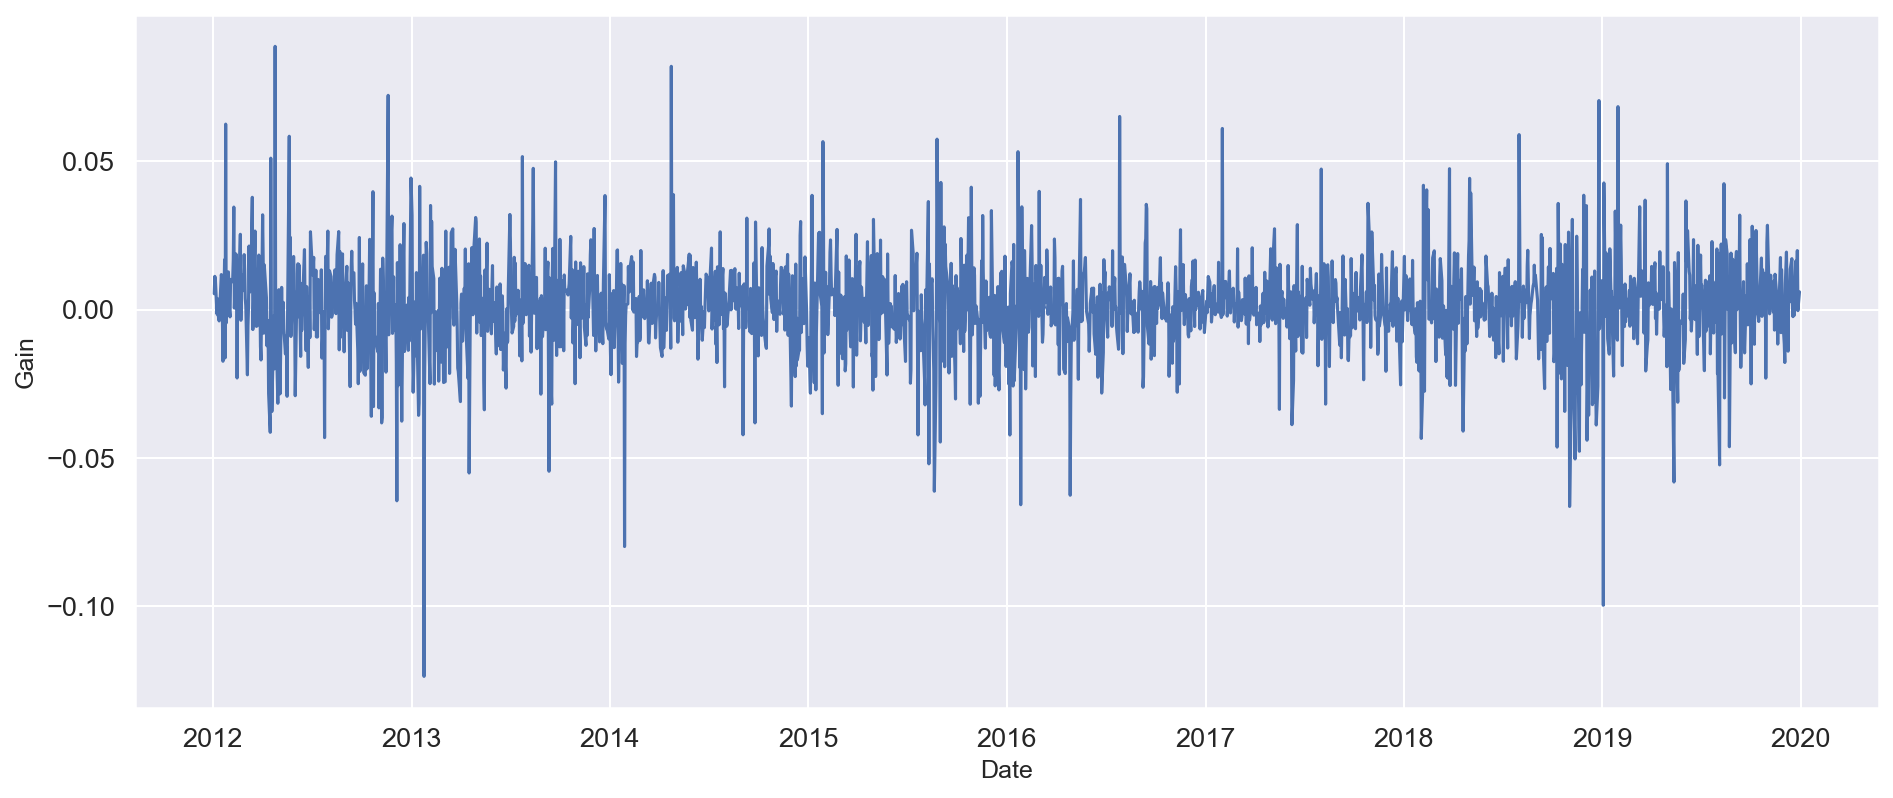

In [44]:
sns.set(rc={'figure.figsize':(15, 6), 'figure.dpi': 150, 'font.size': 16, 'xtick.labelsize': 13, 'ytick.labelsize': 13})
fig = sns.lineplot(df['Gain'])  # figure=plt.figure(figsize=(15, 6))

<Axes: xlabel='Date', ylabel='Volume'>

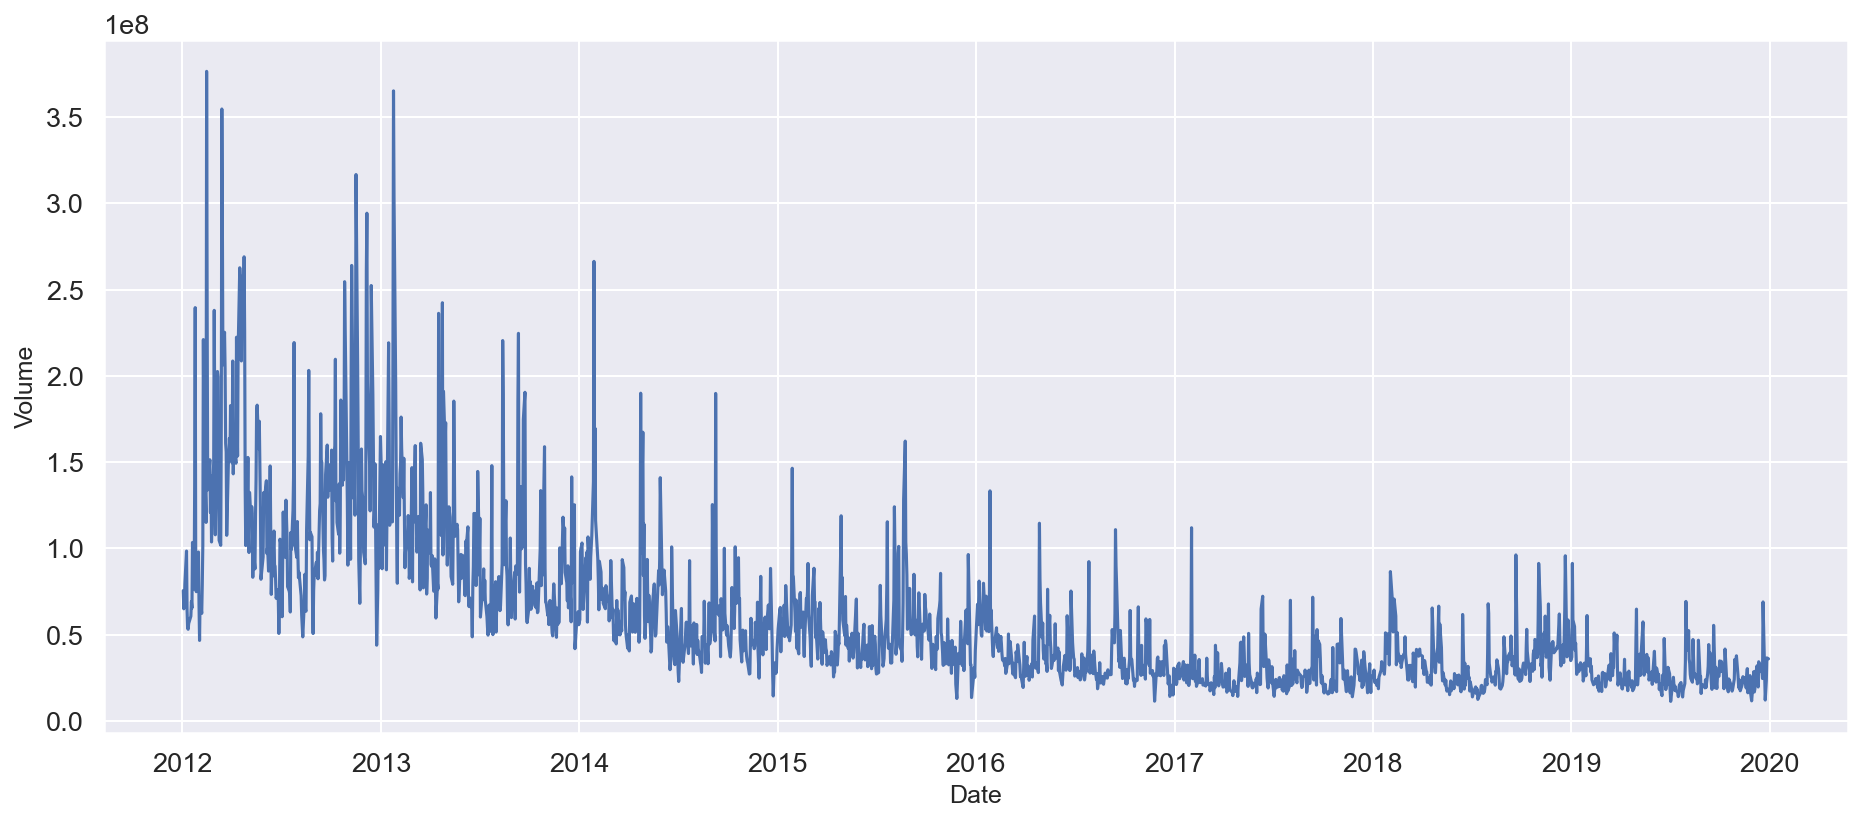

In [45]:
sns.lineplot(df['Volume'])

### Volume vs Adjusted Closing Price

In [46]:
df.corr().loc['Volume']

Open        -0.557957
High        -0.554909
Low         -0.563426
Close       -0.559653
Adj Close   -0.566333
Volume       1.000000
Gain        -0.064259
Name: Volume, dtype: float64

### Checking if data is stationery or non stationery

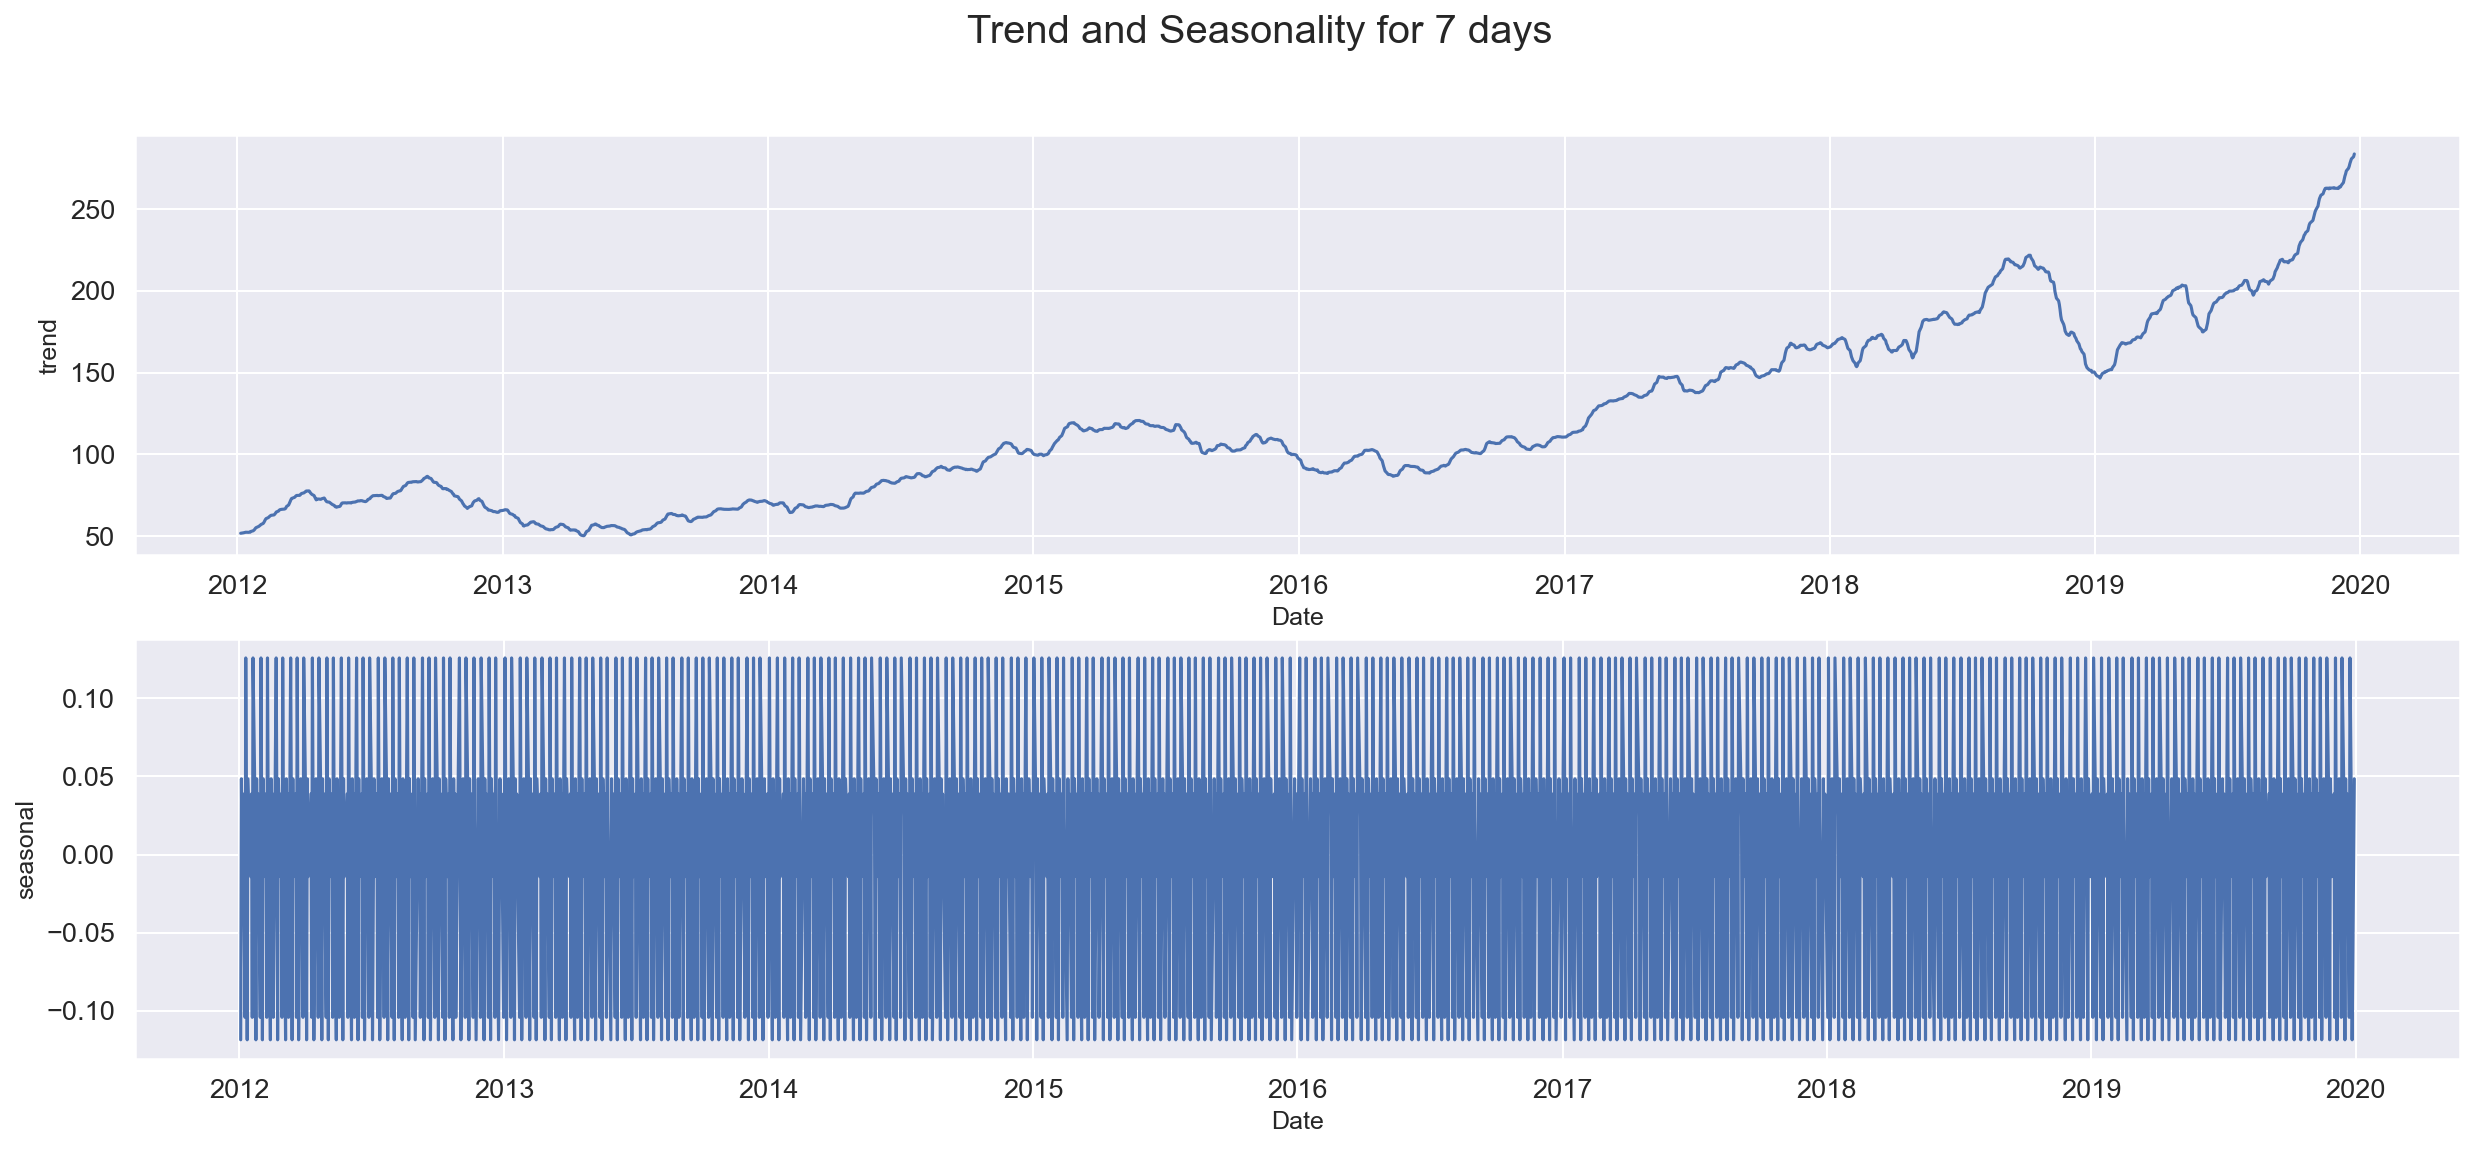

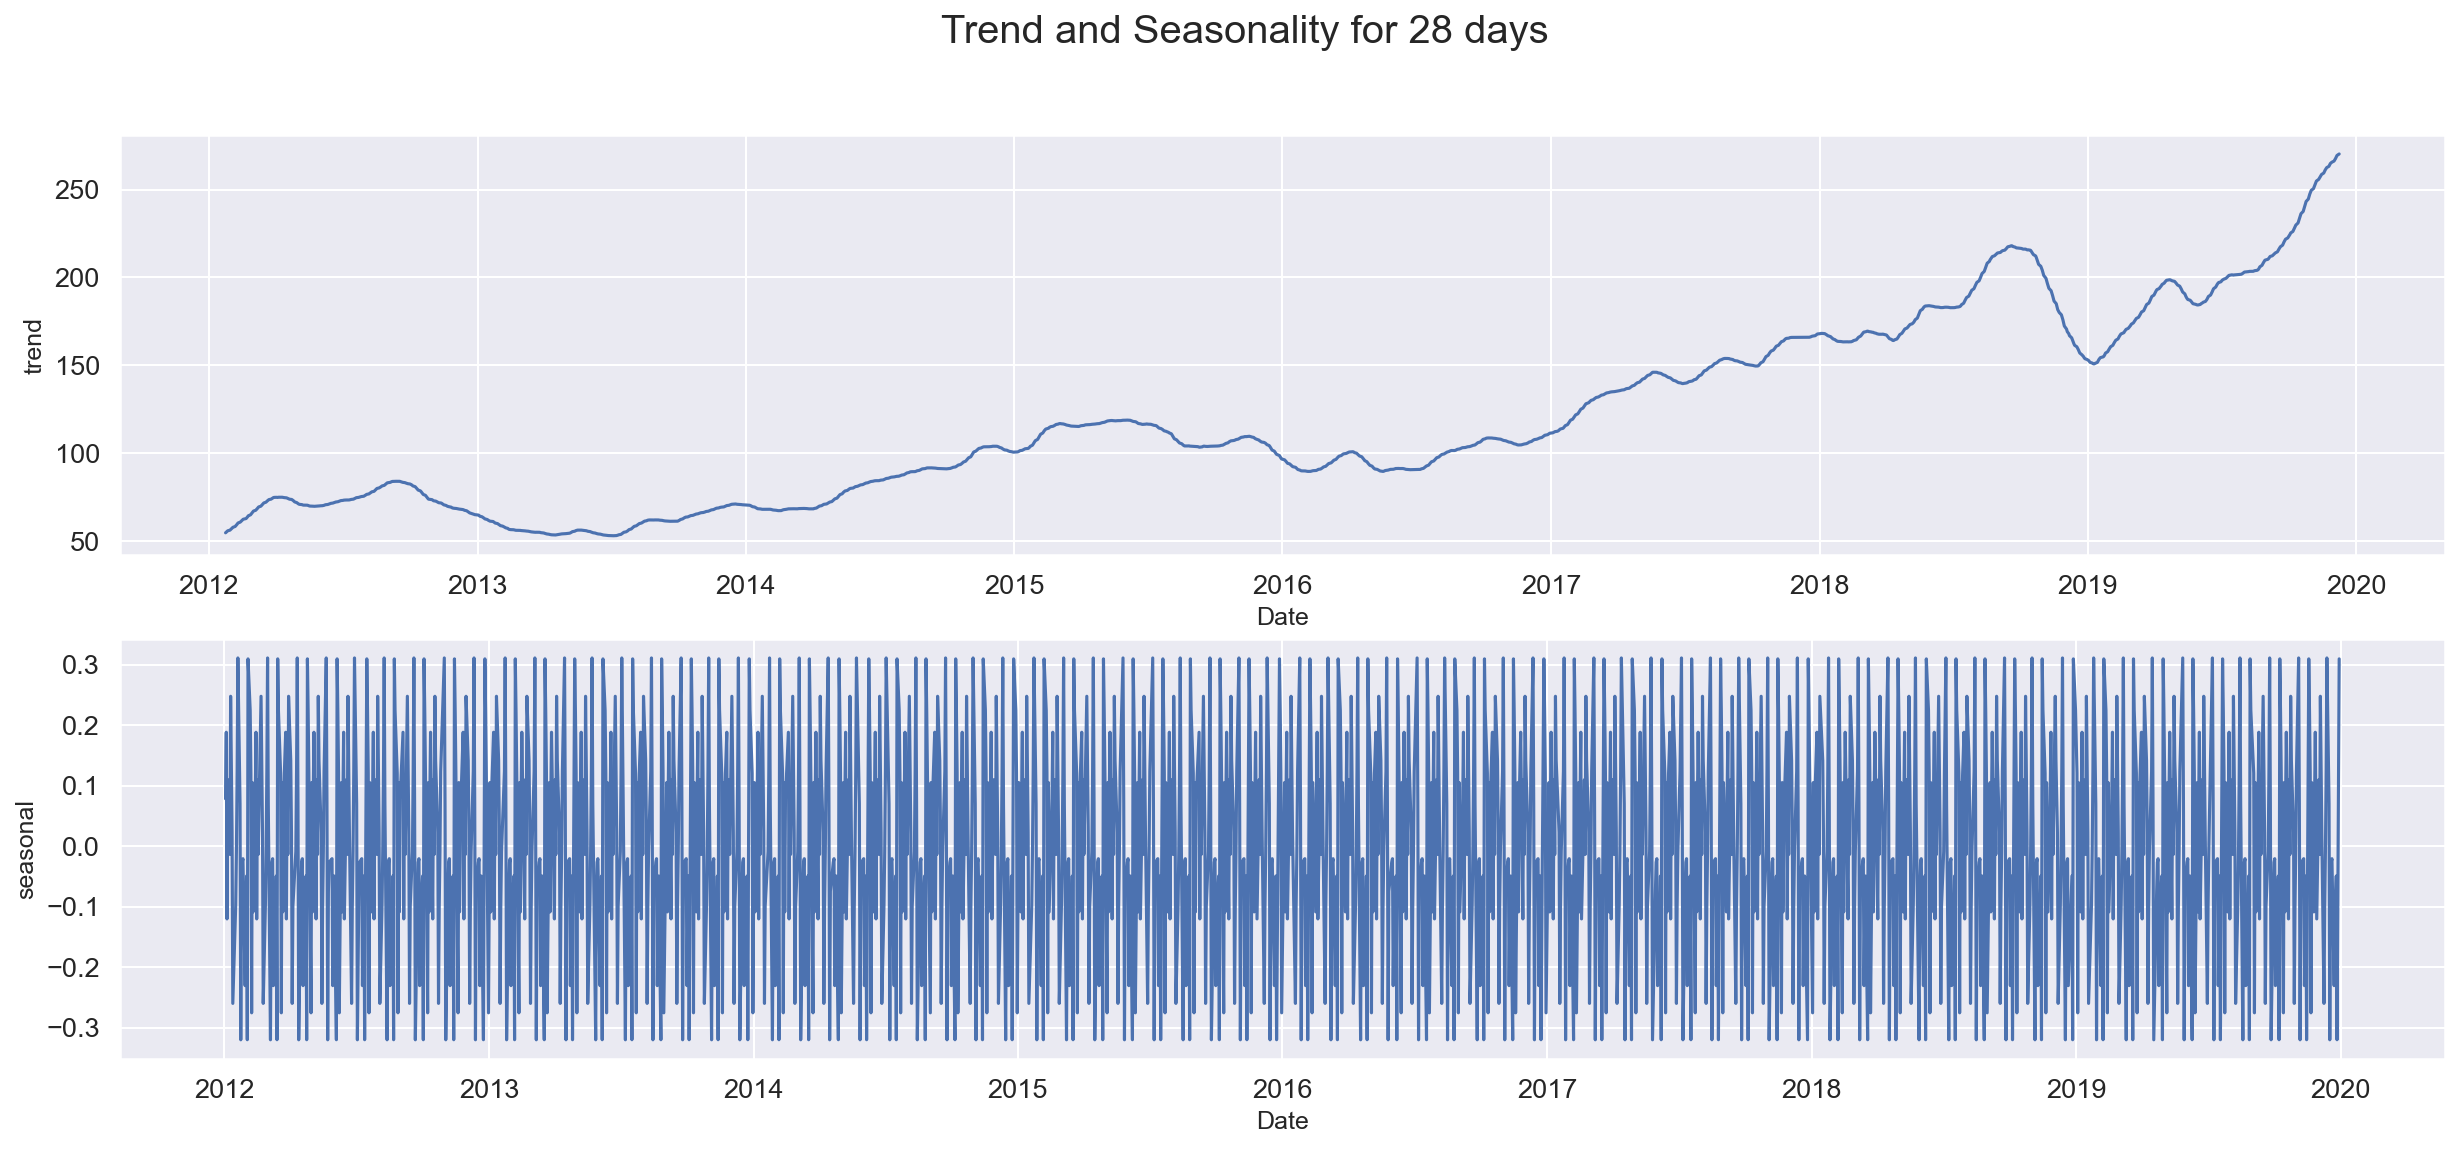

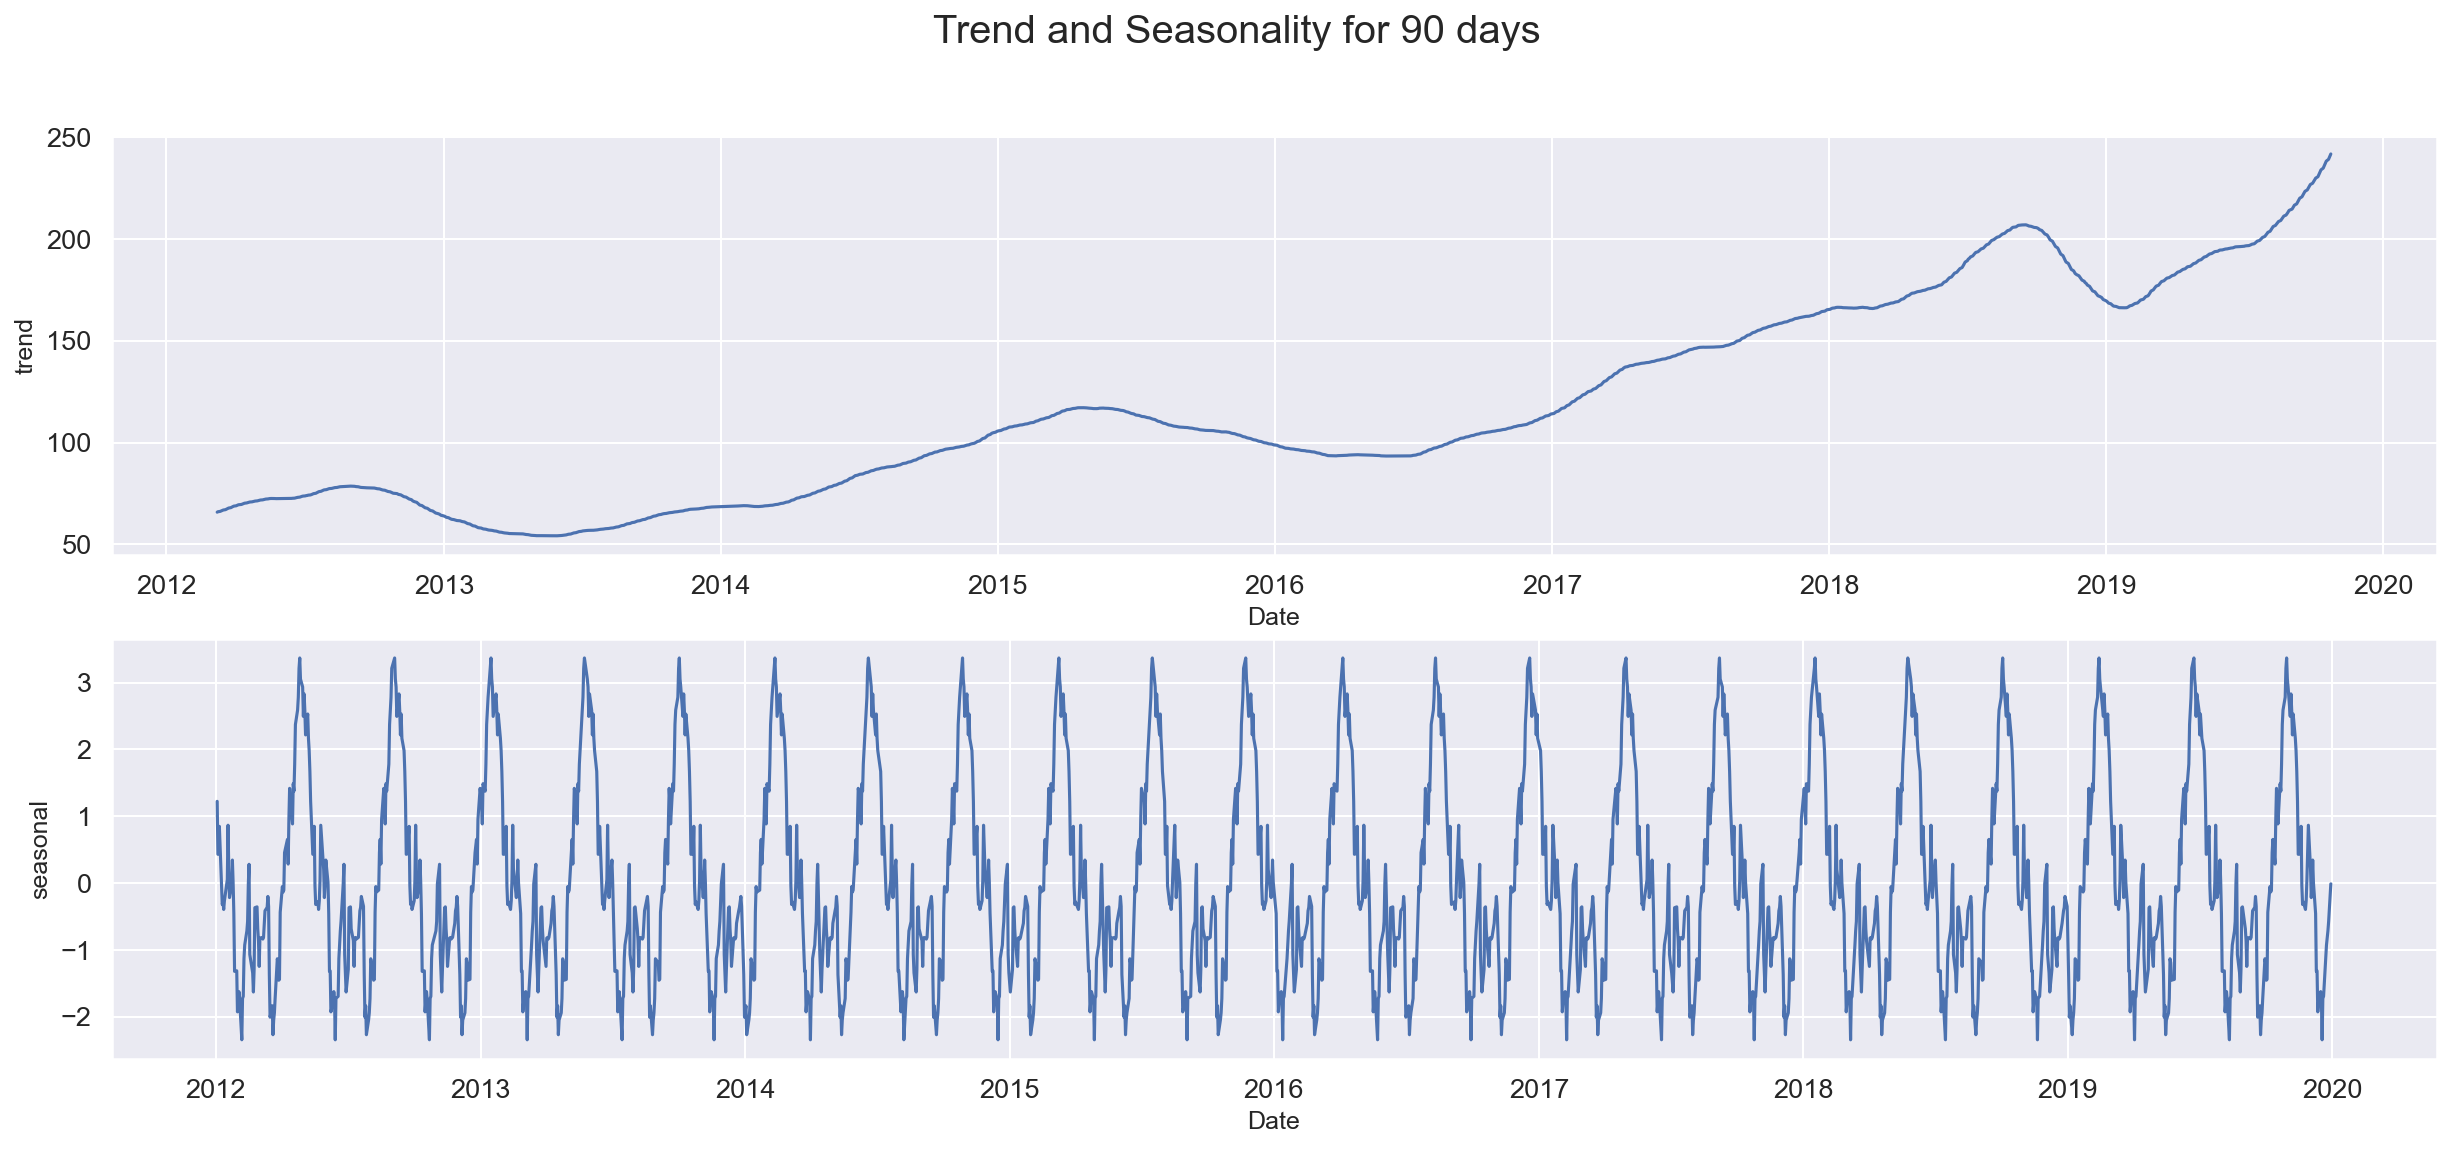

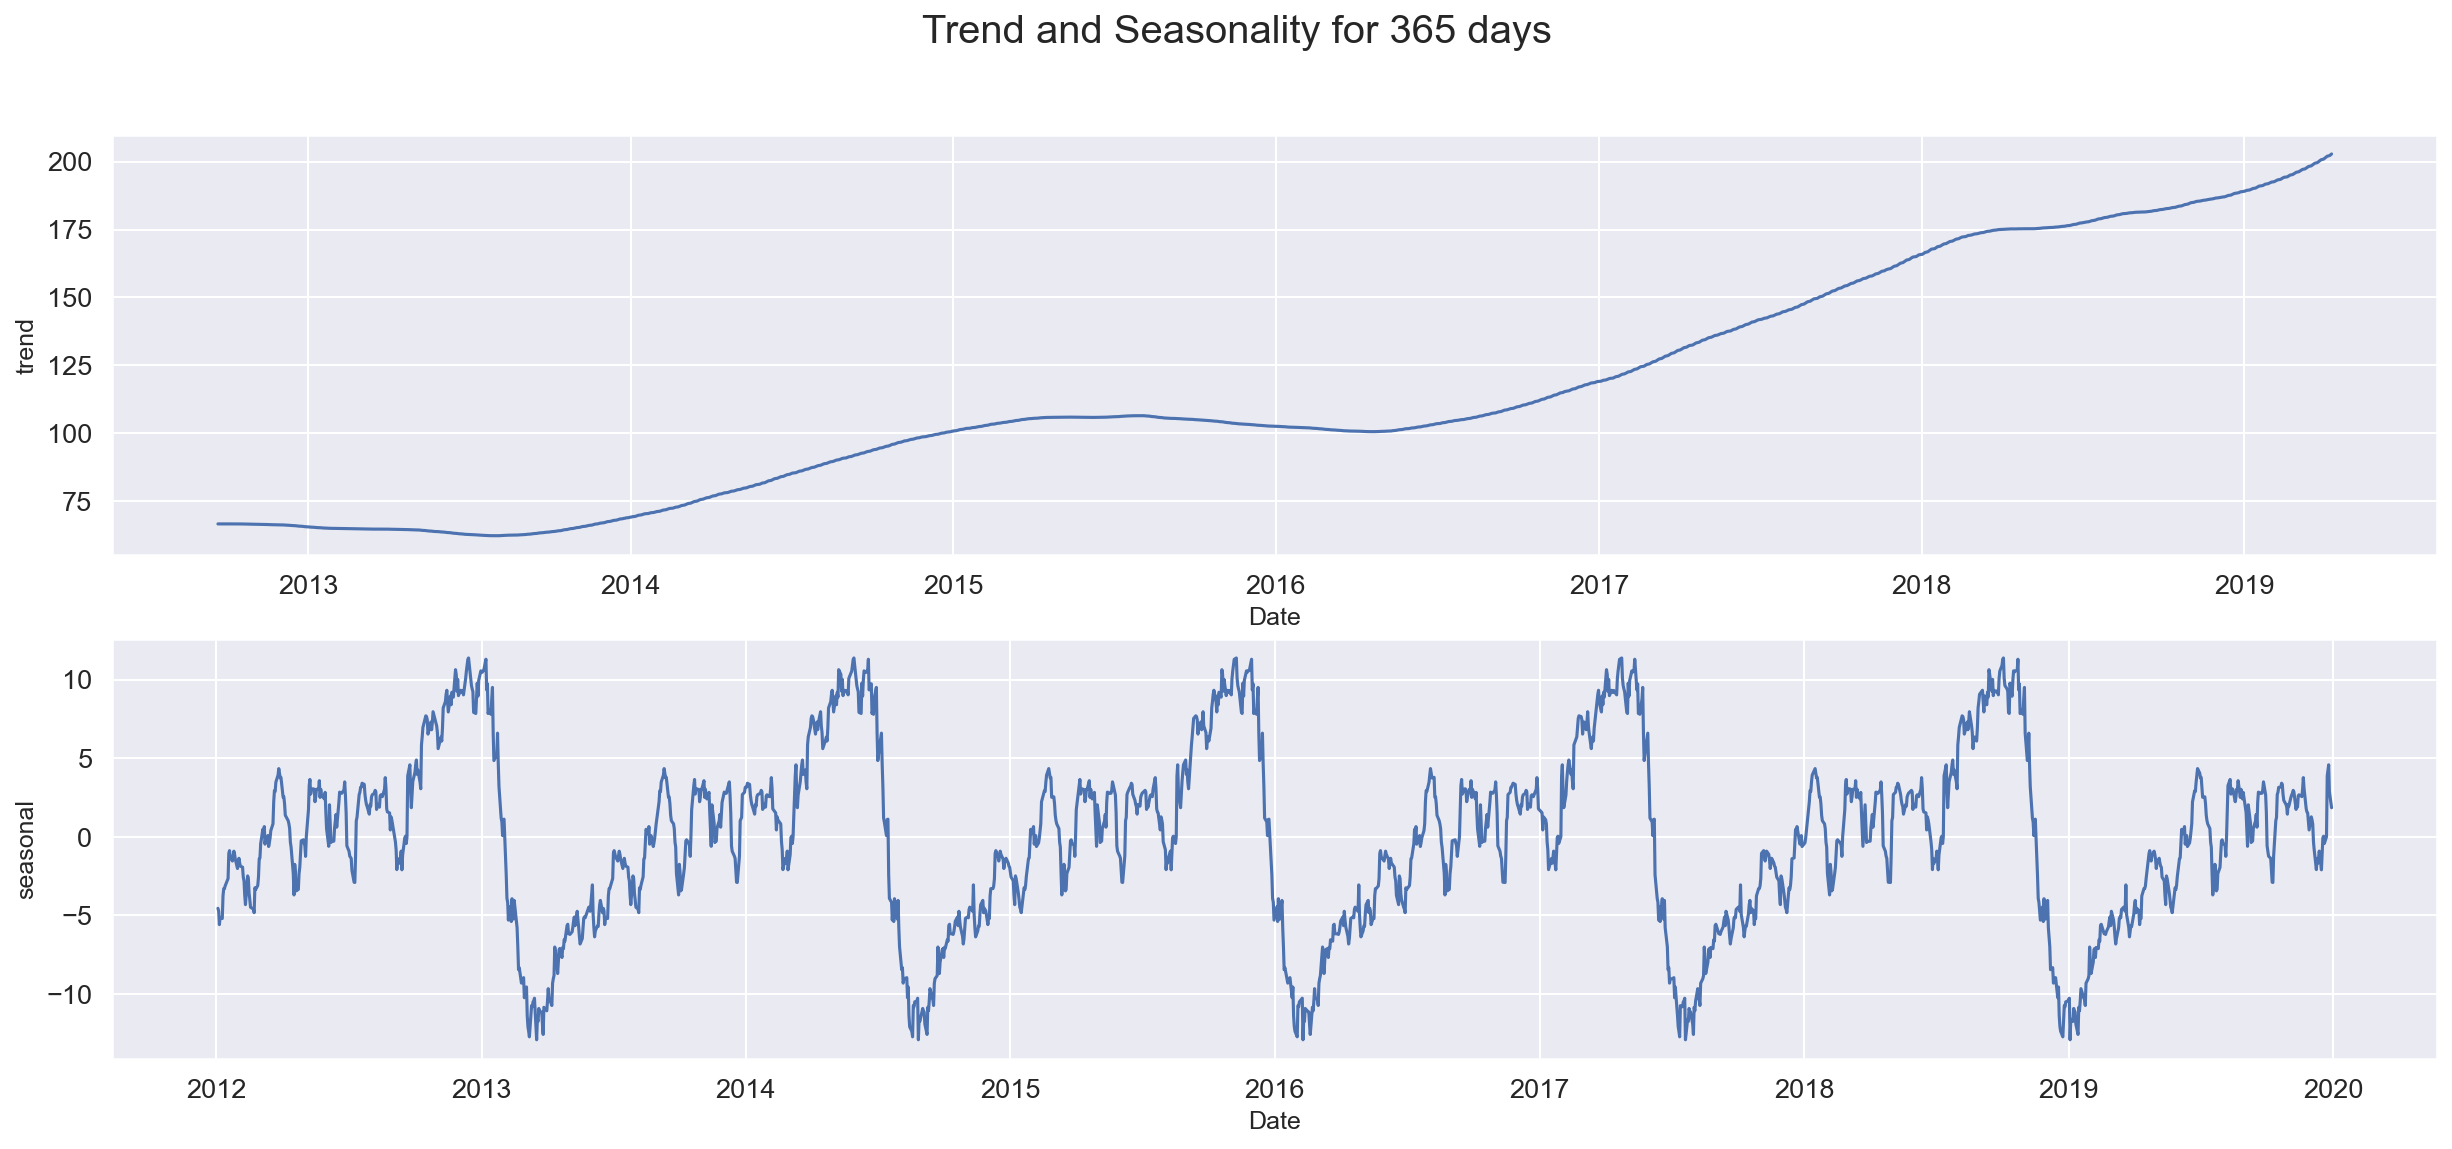

<Figure size 3000x1200 with 0 Axes>

In [47]:
sns.set(rc={'figure.figsize': (20, 8), 'figure.dpi': 150, 'font.size': 16, 'xtick.labelsize': 13, 'ytick.labelsize': 13})
windows = [7, 28, 90, 365]
for window in windows:
    decomp = seasonal_decompose(df['Adj Close'], period=window)
    plt.suptitle(f'Trend and Seasonality for {window} days')
    plt.subplot(2, 1, 1)
    sns.lineplot(decomp.trend)
    plt.subplot(2, 1, 2)
    sns.lineplot(decomp.seasonal)
    plt.show()    
    plt.tight_layout()

#### We can see that there is `upward trend` and `additive seasonality` in the above plots therefore the data is non stationary

### Lineplot with rolling average

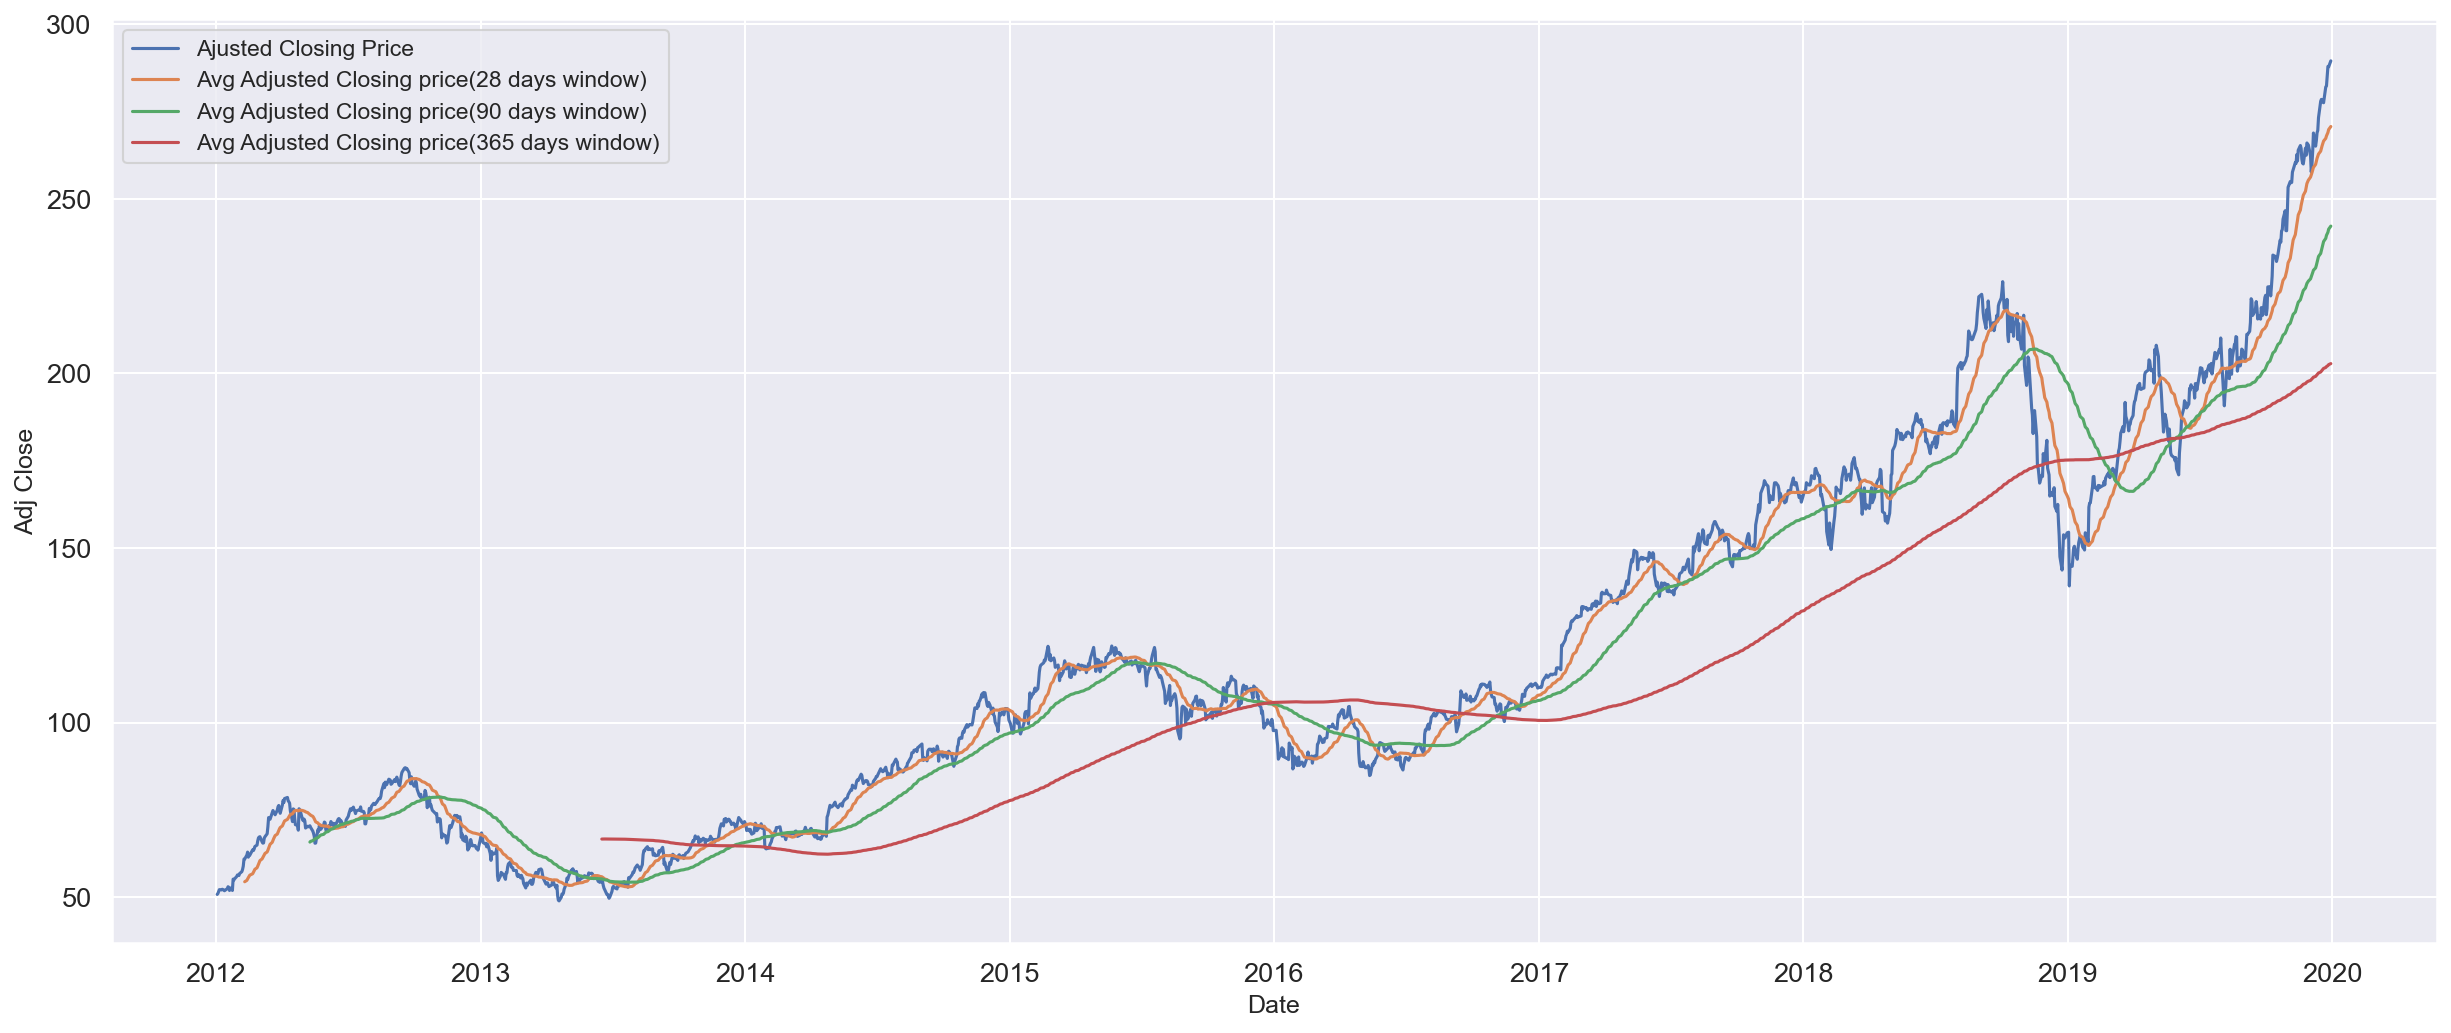

In [48]:
sns.lineplot(df['Adj Close'], label='Ajusted Closing Price')
windows = [28, 90, 365]

for window in windows:
    sns.lineplot(df['Adj Close'].rolling(window).mean(), label=f'Avg Adjusted Closing price({window} days window)')

### Performing Fuller's test to confirm whether the data is stationery or not
### If `pvalue > 0.05` then the data is non stationery else it is stationery

In [49]:
fuller = adfuller(df['Adj Close'])
print(f'pvalue = {fuller[1]}')
if fuller[1] < 0.05:
    print('Data is stationery')
else:
    print('Data is non stationery')

pvalue = 0.9973451971291782
Data is non stationery


## As we can see that the data is not stationery we can perform one of the following to make data stationery

# DIFFERENCING TO MAKE DATA STATIONARY

In [51]:
# Take the log of the 'Adj Close' column
df['Adj Close_log'] = np.log(df['Adj Close'])
df

Open    High     Low   Close  Adj Close    Volume      Gain  \
Date                                                                        
2012-01-03   58.49   58.93   58.43   58.75      50.77  75555200       NaN   
2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500  0.005318   
2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400  0.011168   
2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200  0.010269   
2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100 -0.001534   
...            ...     ...     ...     ...        ...       ...       ...   
2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000  0.016287   
2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700  0.000957   
2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300  0.019836   
2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500 -0.000382   
2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600  0.005941   

           Month  Year Day  Adj Close_log  
Date                                       
2012-01-03   Jan  2012  03       3.927306  
2012-01-04   Jan  2012  04       3.932610  
2012-01-05   Jan  2012  05       3.943715  
2012-01-06   Jan  2012  06       3.953932  
2012-01-09   Jan  2012  09       3.952397  
...          ...   ...  ..            ...  
2019-12-23   Dec  2019  23       5.642084  
2019-12-24   Dec  2019  24       5.643041  
2019-12-26   Dec  2019  26       5.662683  
2019-12-27   Dec  2019  27       5.662301  
2019-12-30   Dec  2019  30       5.668224  

[2011 rows x 11 columns]

In [54]:
# First-order differencing
df['Adj Close_diff'] = df['Adj Close_log'].diff()
df

Open    High     Low   Close  Adj Close    Volume      Gain  \
Date                                                                        
2012-01-03   58.49   58.93   58.43   58.75      50.77  75555200       NaN   
2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500  0.005318   
2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400  0.011168   
2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200  0.010269   
2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100 -0.001534   
...            ...     ...     ...     ...        ...       ...       ...   
2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000  0.016287   
2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700  0.000957   
2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300  0.019836   
2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500 -0.000382   
2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600  0.005941   

           Month  Year Day  Adj Close_log  Adj Close_diff  
Date                                                       
2012-01-03   Jan  2012  03       3.927306             NaN  
2012-01-04   Jan  2012  04       3.932610        0.005304  
2012-01-05   Jan  2012  05       3.943715        0.011106  
2012-01-06   Jan  2012  06       3.953932        0.010217  
2012-01-09   Jan  2012  09       3.952397       -0.001536  
...          ...   ...  ..            ...             ...  
2019-12-23   Dec  2019  23       5.642084        0.016155  
2019-12-24   Dec  2019  24       5.643041        0.000957  
2019-12-26   Dec  2019  26       5.662683        0.019641  
2019-12-27   Dec  2019  27       5.662301       -0.000382  
2019-12-30   Dec  2019  30       5.668224        0.005924  

[2011 rows x 12 columns]

In [55]:
# Drop the first row with NaN value
df.dropna(inplace=True)

In [56]:
# Check if the transformed data is stationary
result = adfuller(df['Adj Close_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.710605
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### Based on the ADF statistic and p-value, it appears that the data is stationary

#### The ADF statistic is significantly less than the critical values at all levels 
#### (1% 5% and 10%) and the p-value is less than 0.05 

#### Therefore, we can reject the null hypothesis of non-stationarity and conclude that the data is stationary.

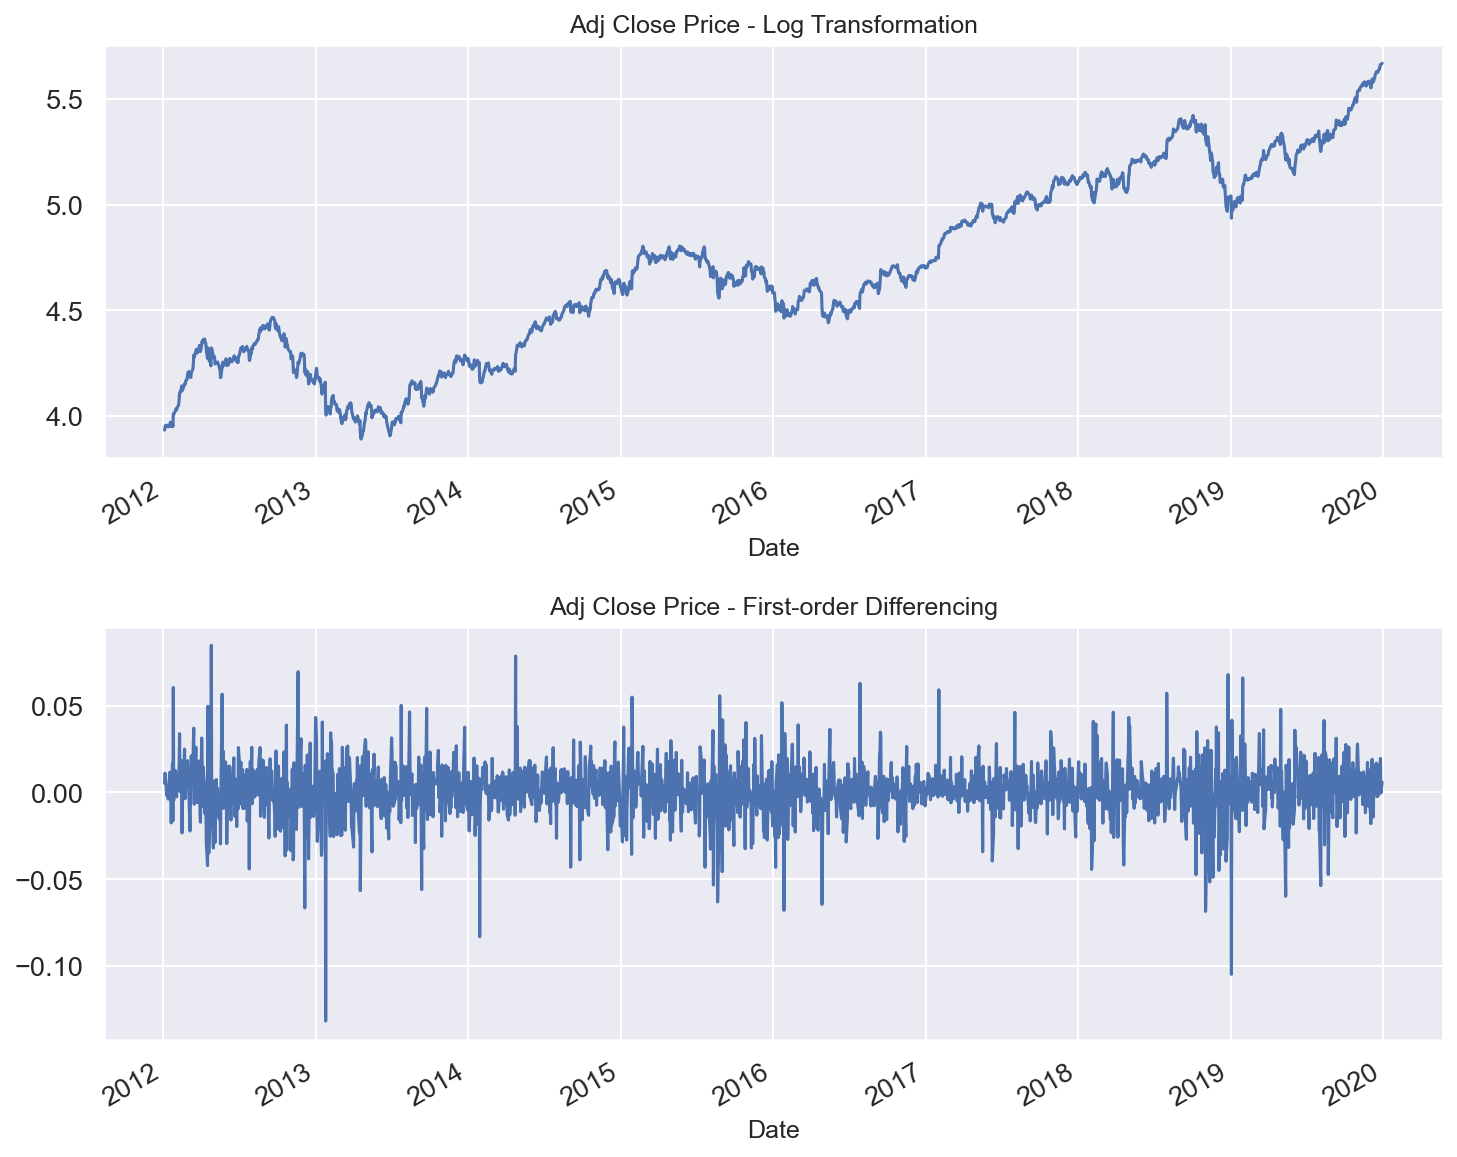

In [57]:
# Plot the time series data
fig, ax = plt.subplots(2, 1, figsize=(10,8))
df['Adj Close_log'].plot(ax=ax[0])
ax[0].set(title='Adj Close Price - Log Transformation')
df['Adj Close_diff'].plot(ax=ax[1])
ax[1].set(title='Adj Close Price - First-order Differencing')
plt.tight_layout()
plt.show()

In [58]:
# Take the first difference of the 'Adj Close' column to make the data stationary
df_diff = df['Adj Close'].diff().dropna()

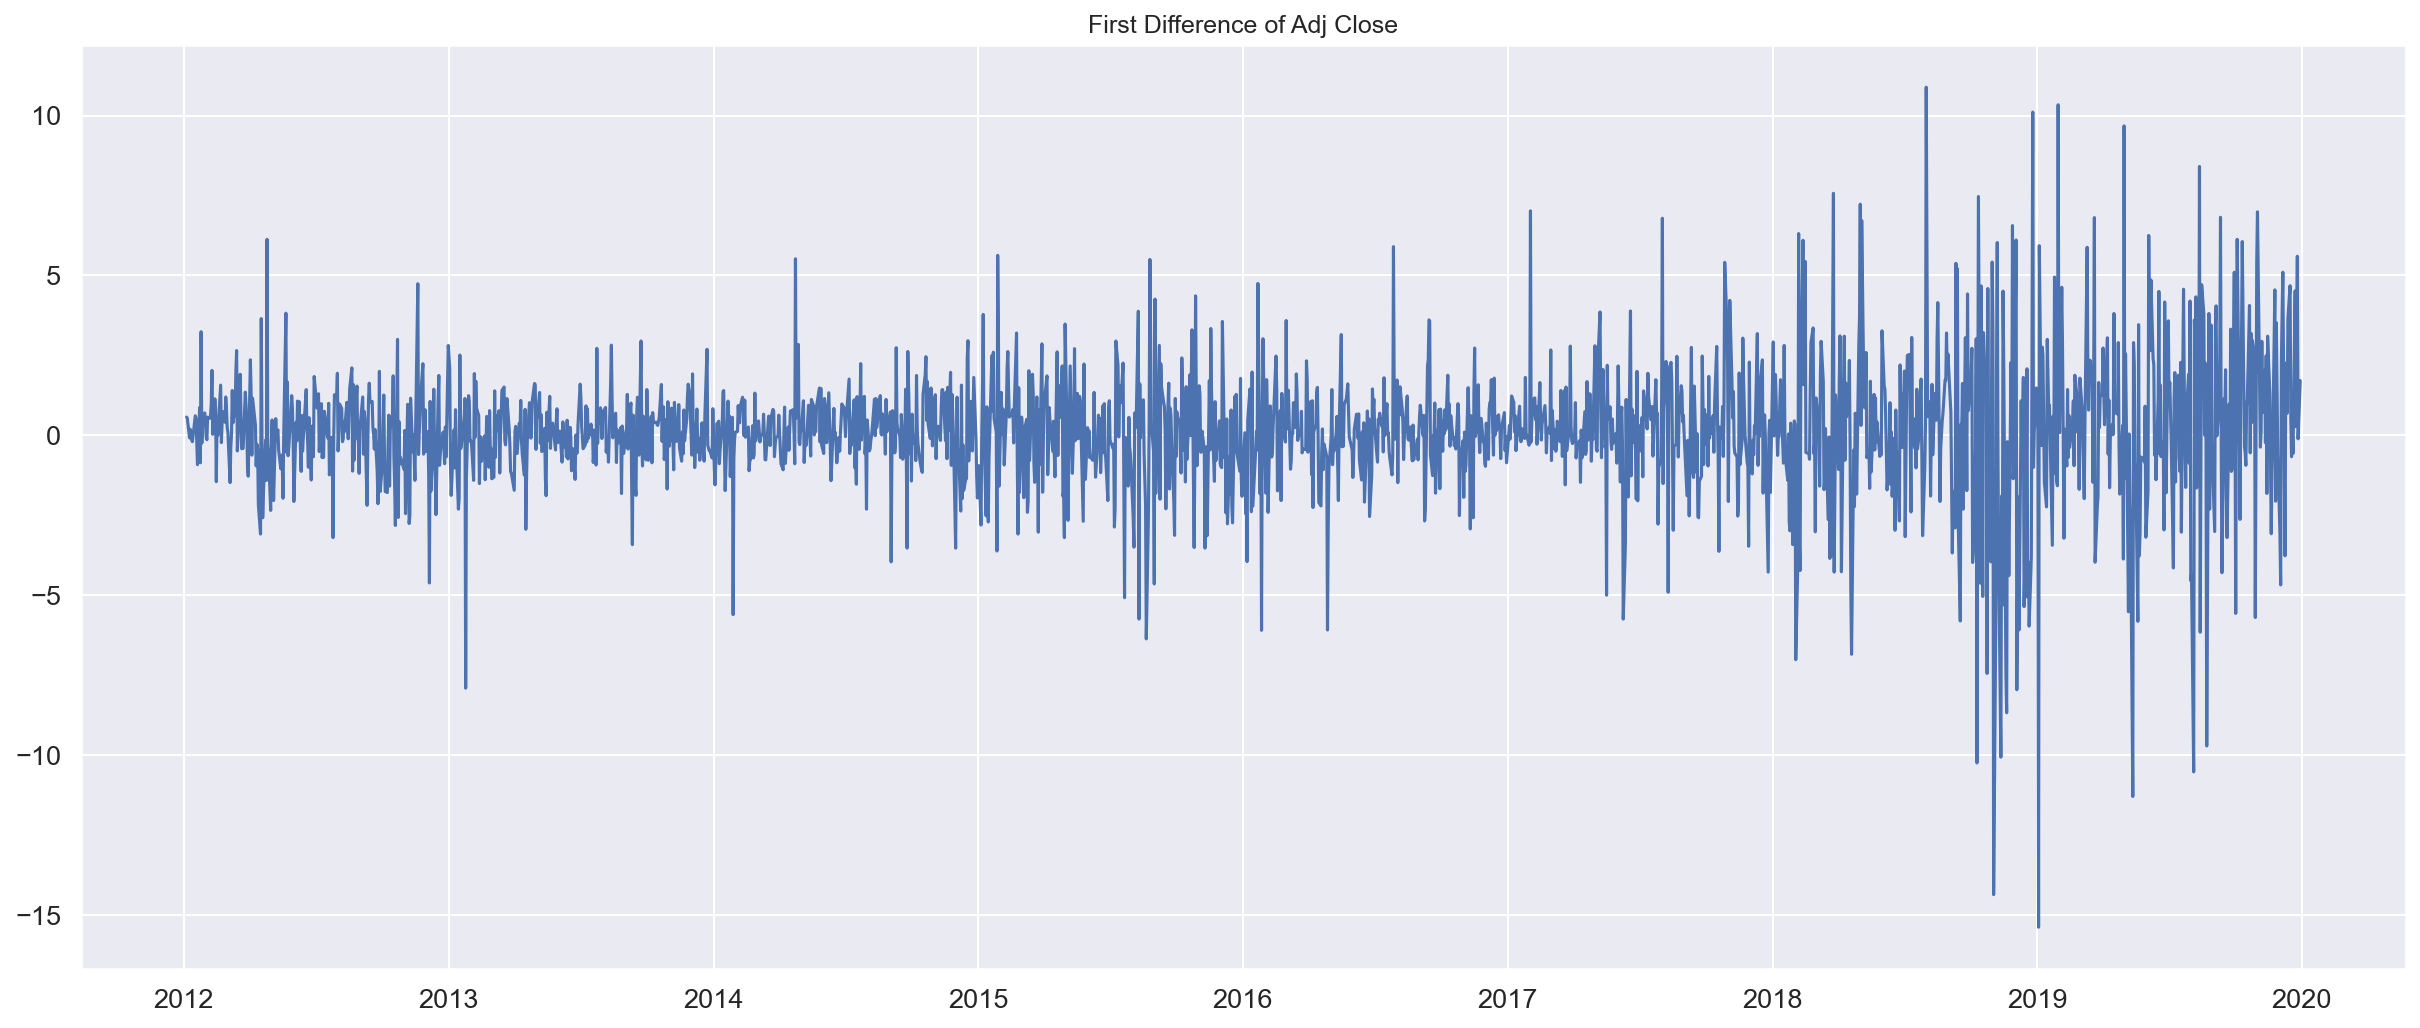

In [59]:
# Plot the time series data
plt.plot(df_diff)
plt.title('First Difference of Adj Close')
plt.show()

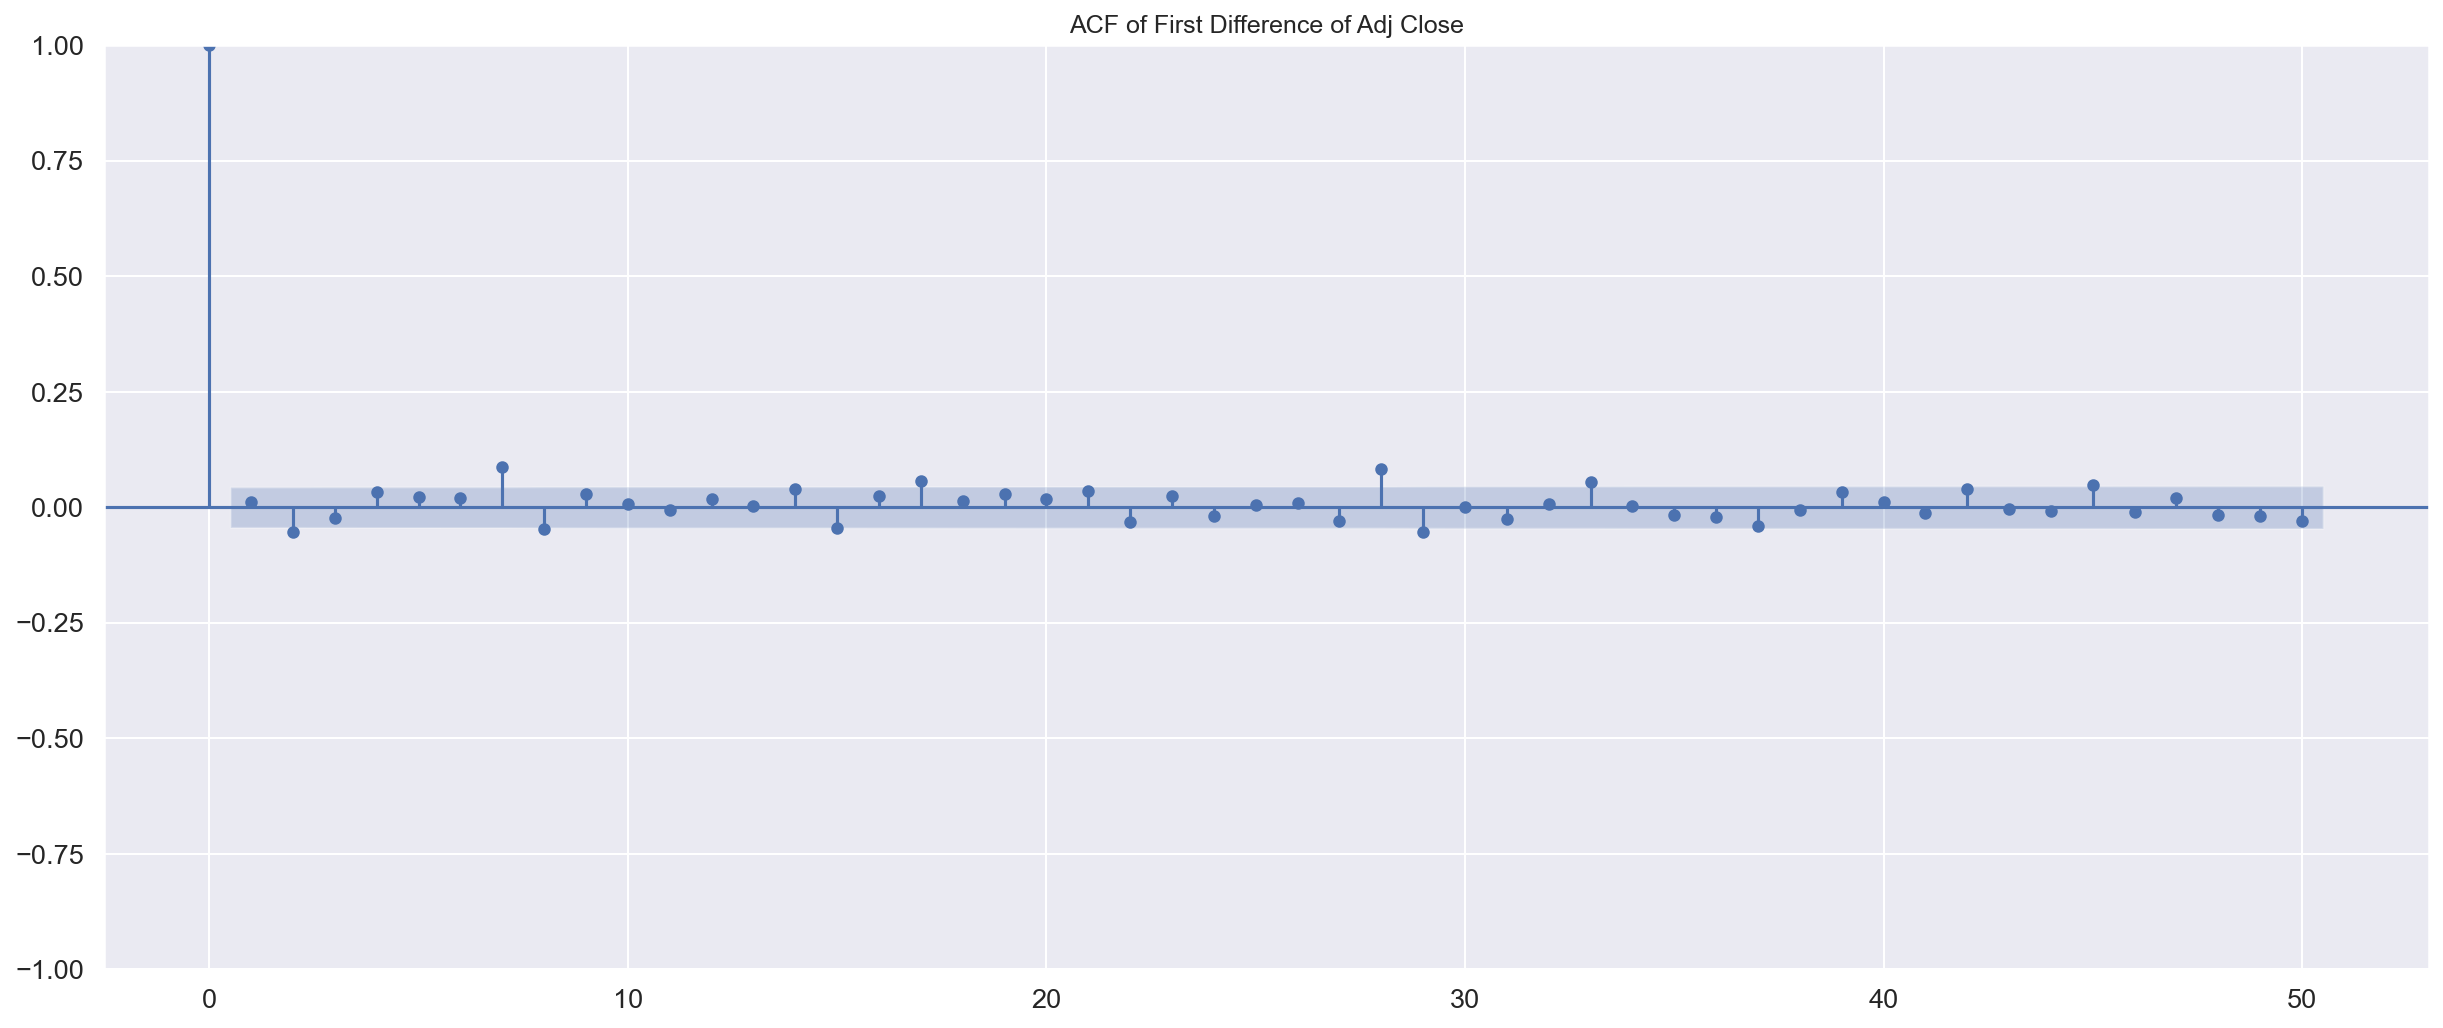

In [61]:
# Plot the ACF and PACF of the stationary data
plot_acf(df_diff, lags=50)
plt.title('ACF of First Difference of Adj Close')
plt.show()


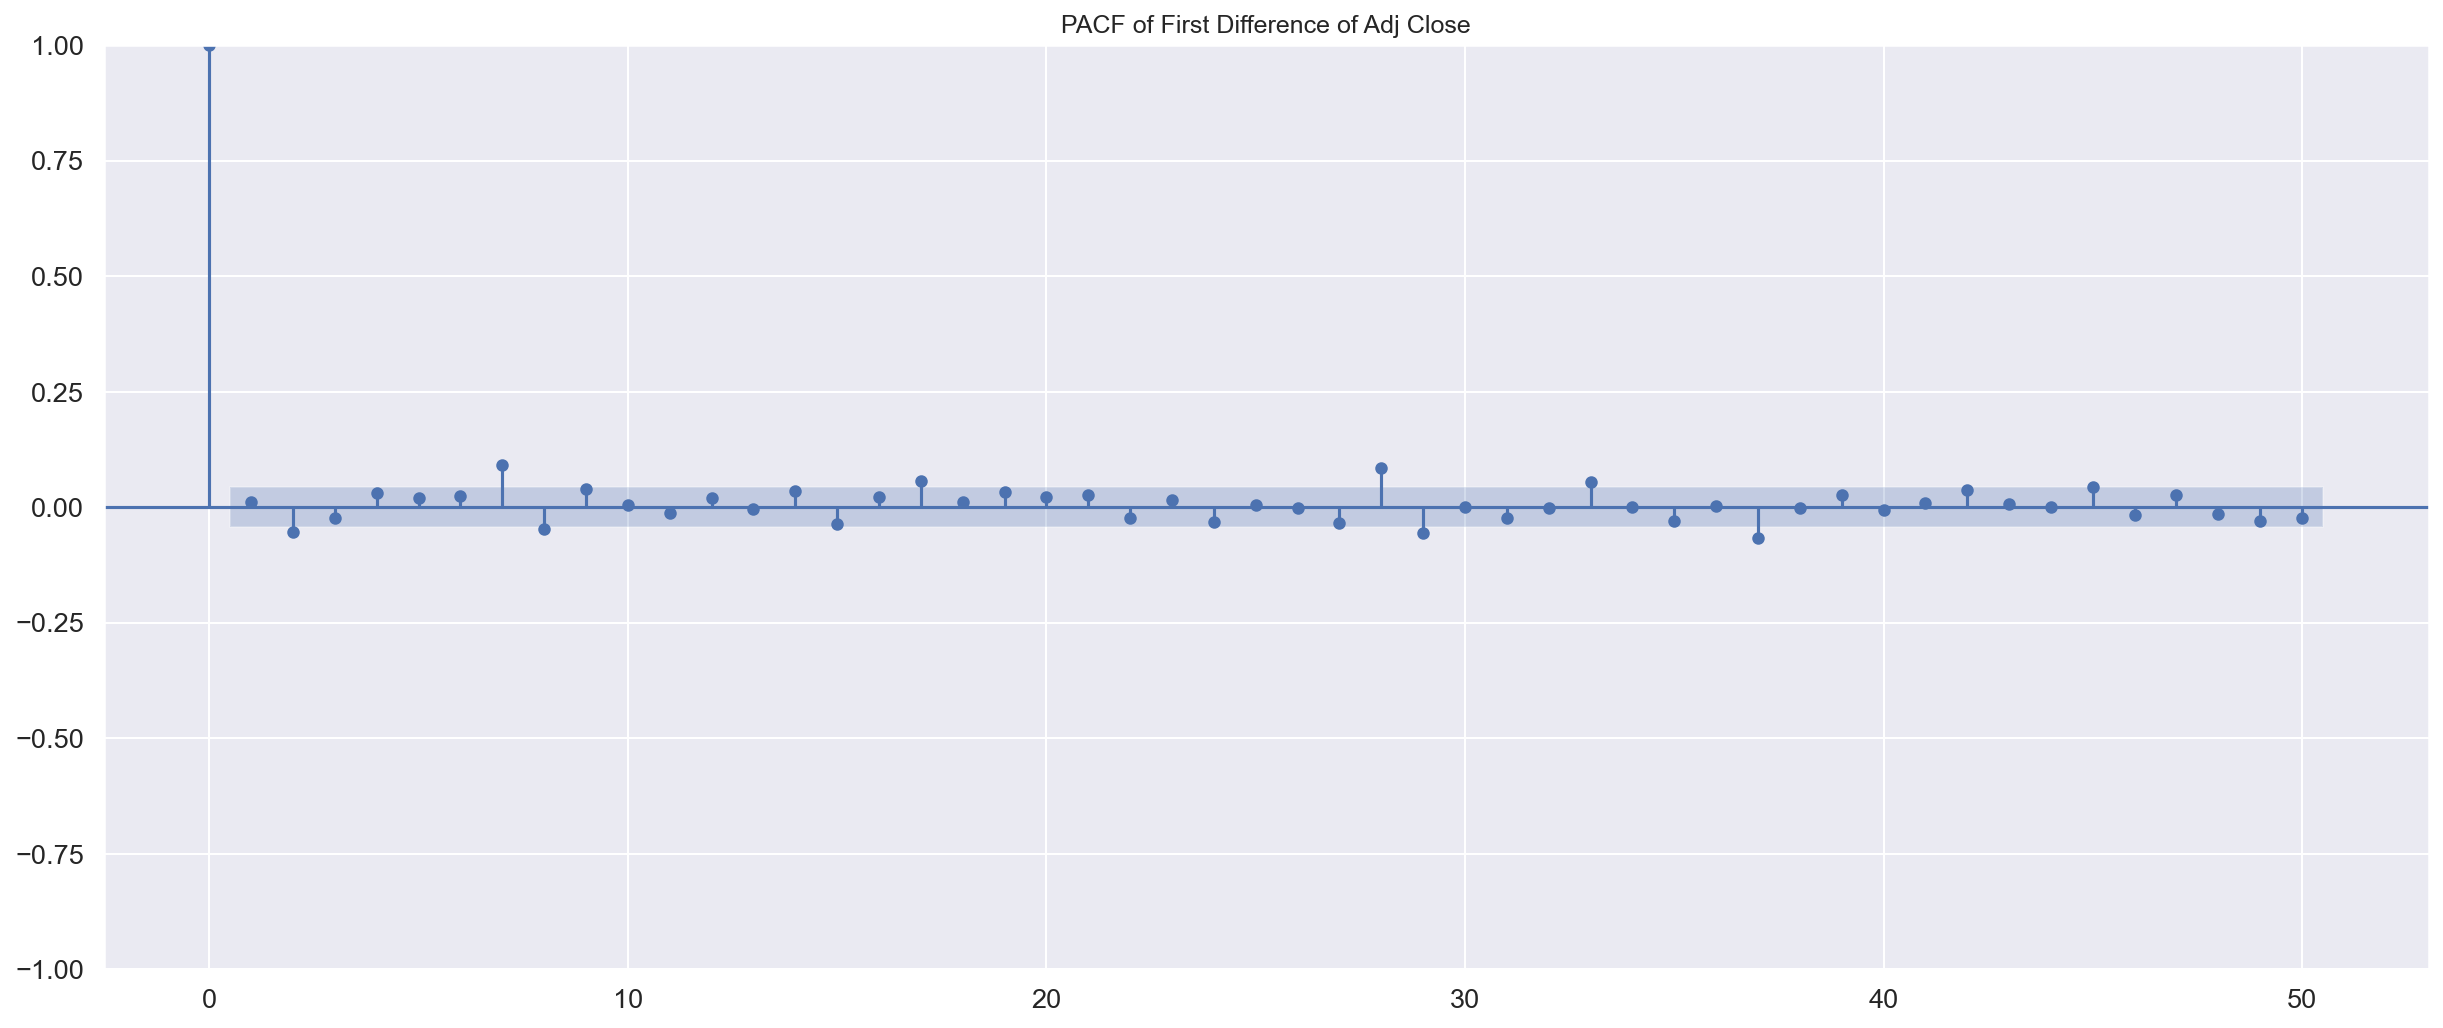

In [62]:
plot_pacf(df_diff, lags=50)
plt.title('PACF of First Difference of Adj Close')
plt.show()

In [63]:
# Create a differenced series to make the data stationary
differenced_data = df['Adj Close'].diff().dropna()

Text(0, 0.5, 'Difference')

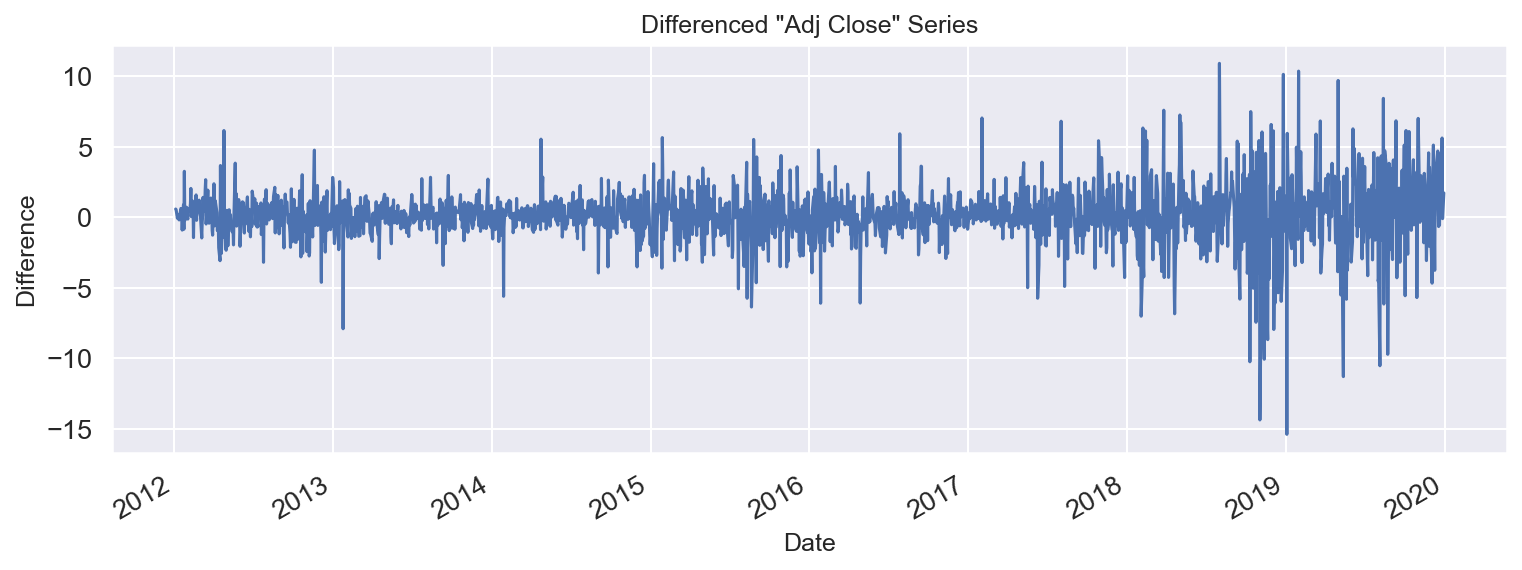

In [64]:
# Plot the differenced series
fig, ax = plt.subplots(figsize=(12, 4))
df_diff.plot(ax=ax)
ax.set_title('Differenced "Adj Close" Series')
ax.set_xlabel('Date')
ax.set_ylabel('Difference')


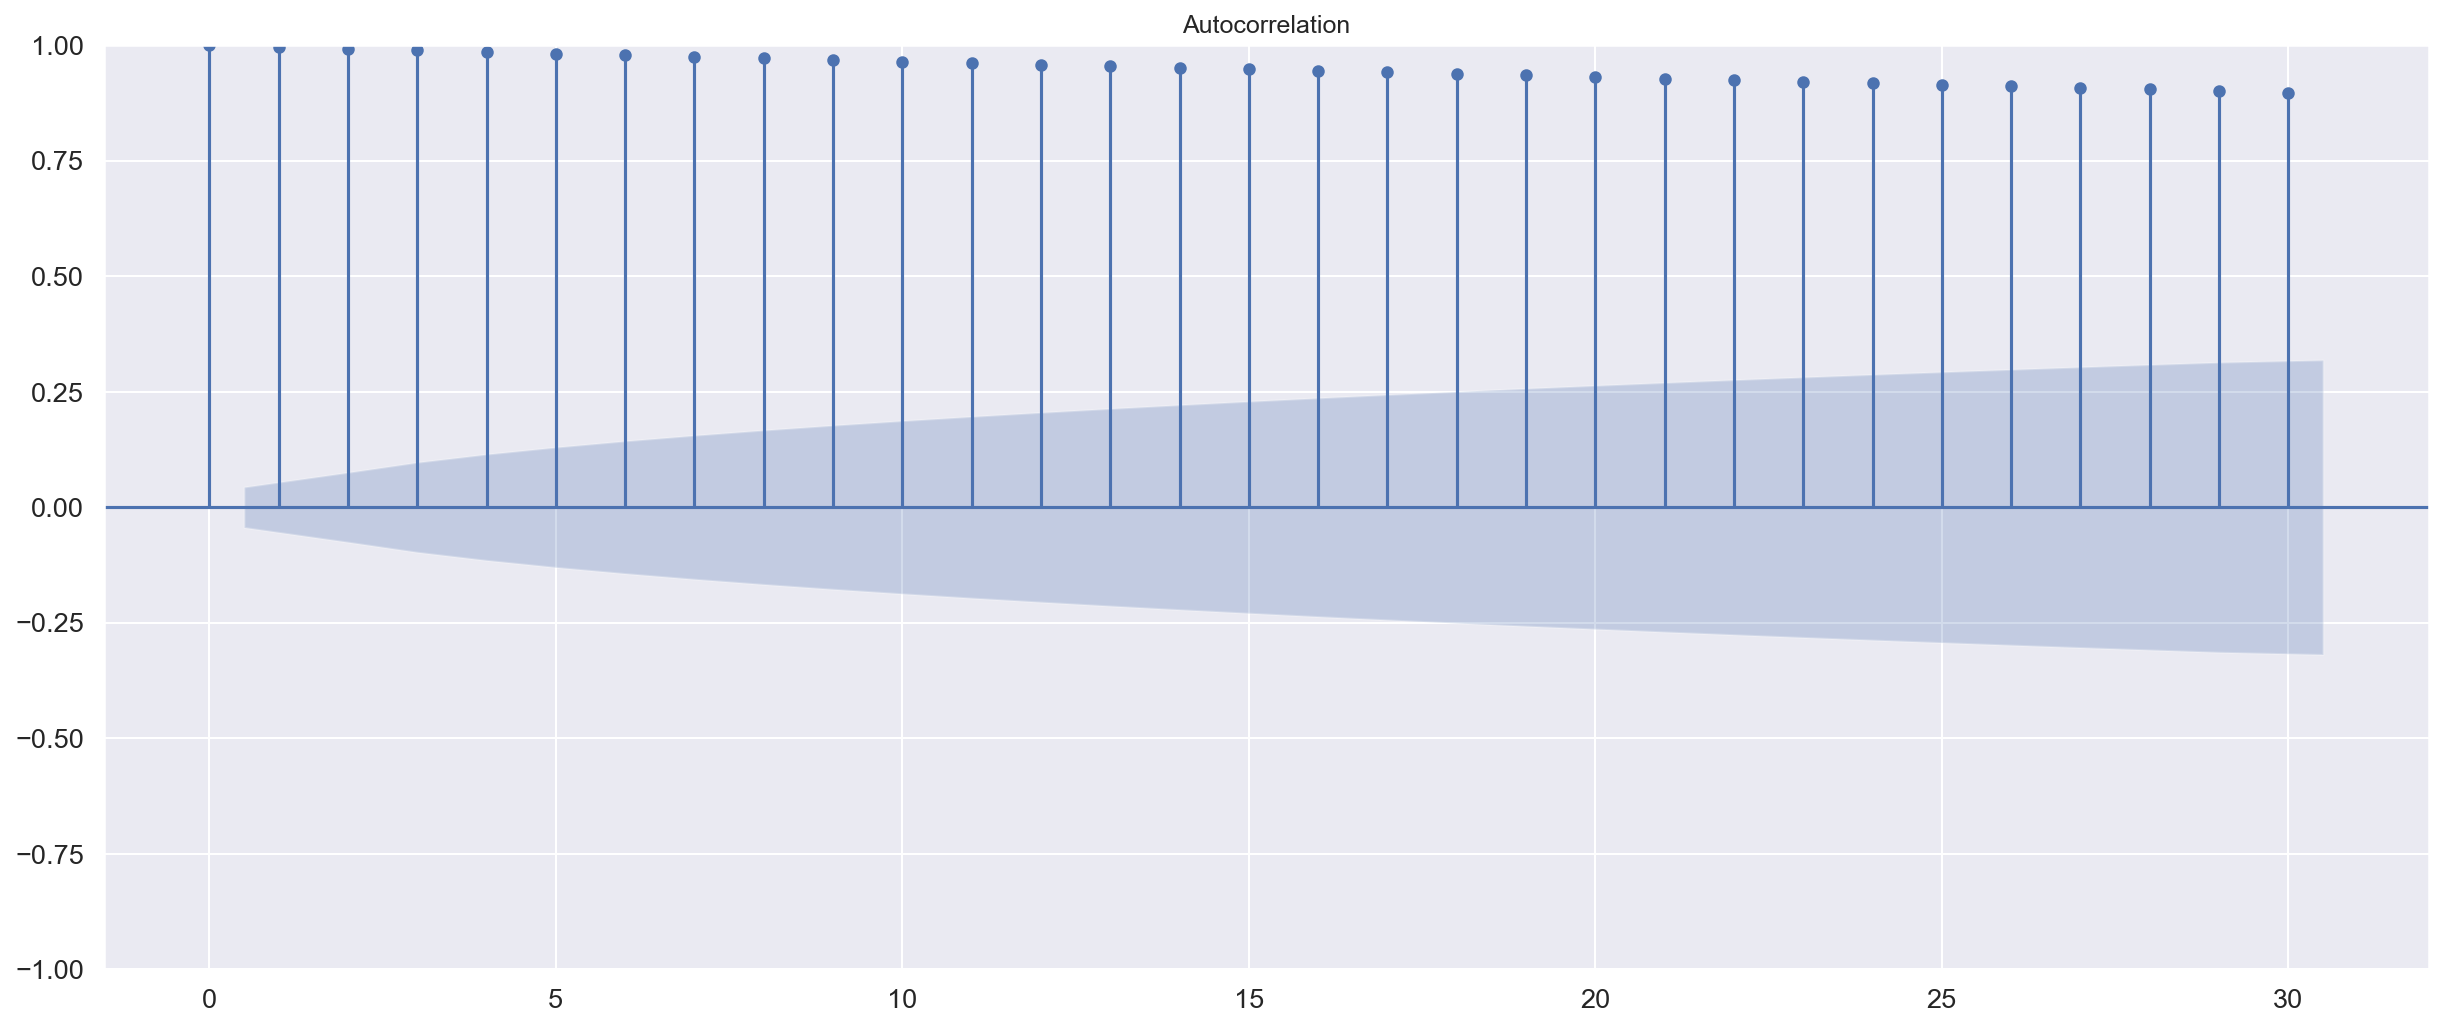

In [65]:
#Plot ACF
plot_acf(df['Adj Close'], lags=30);

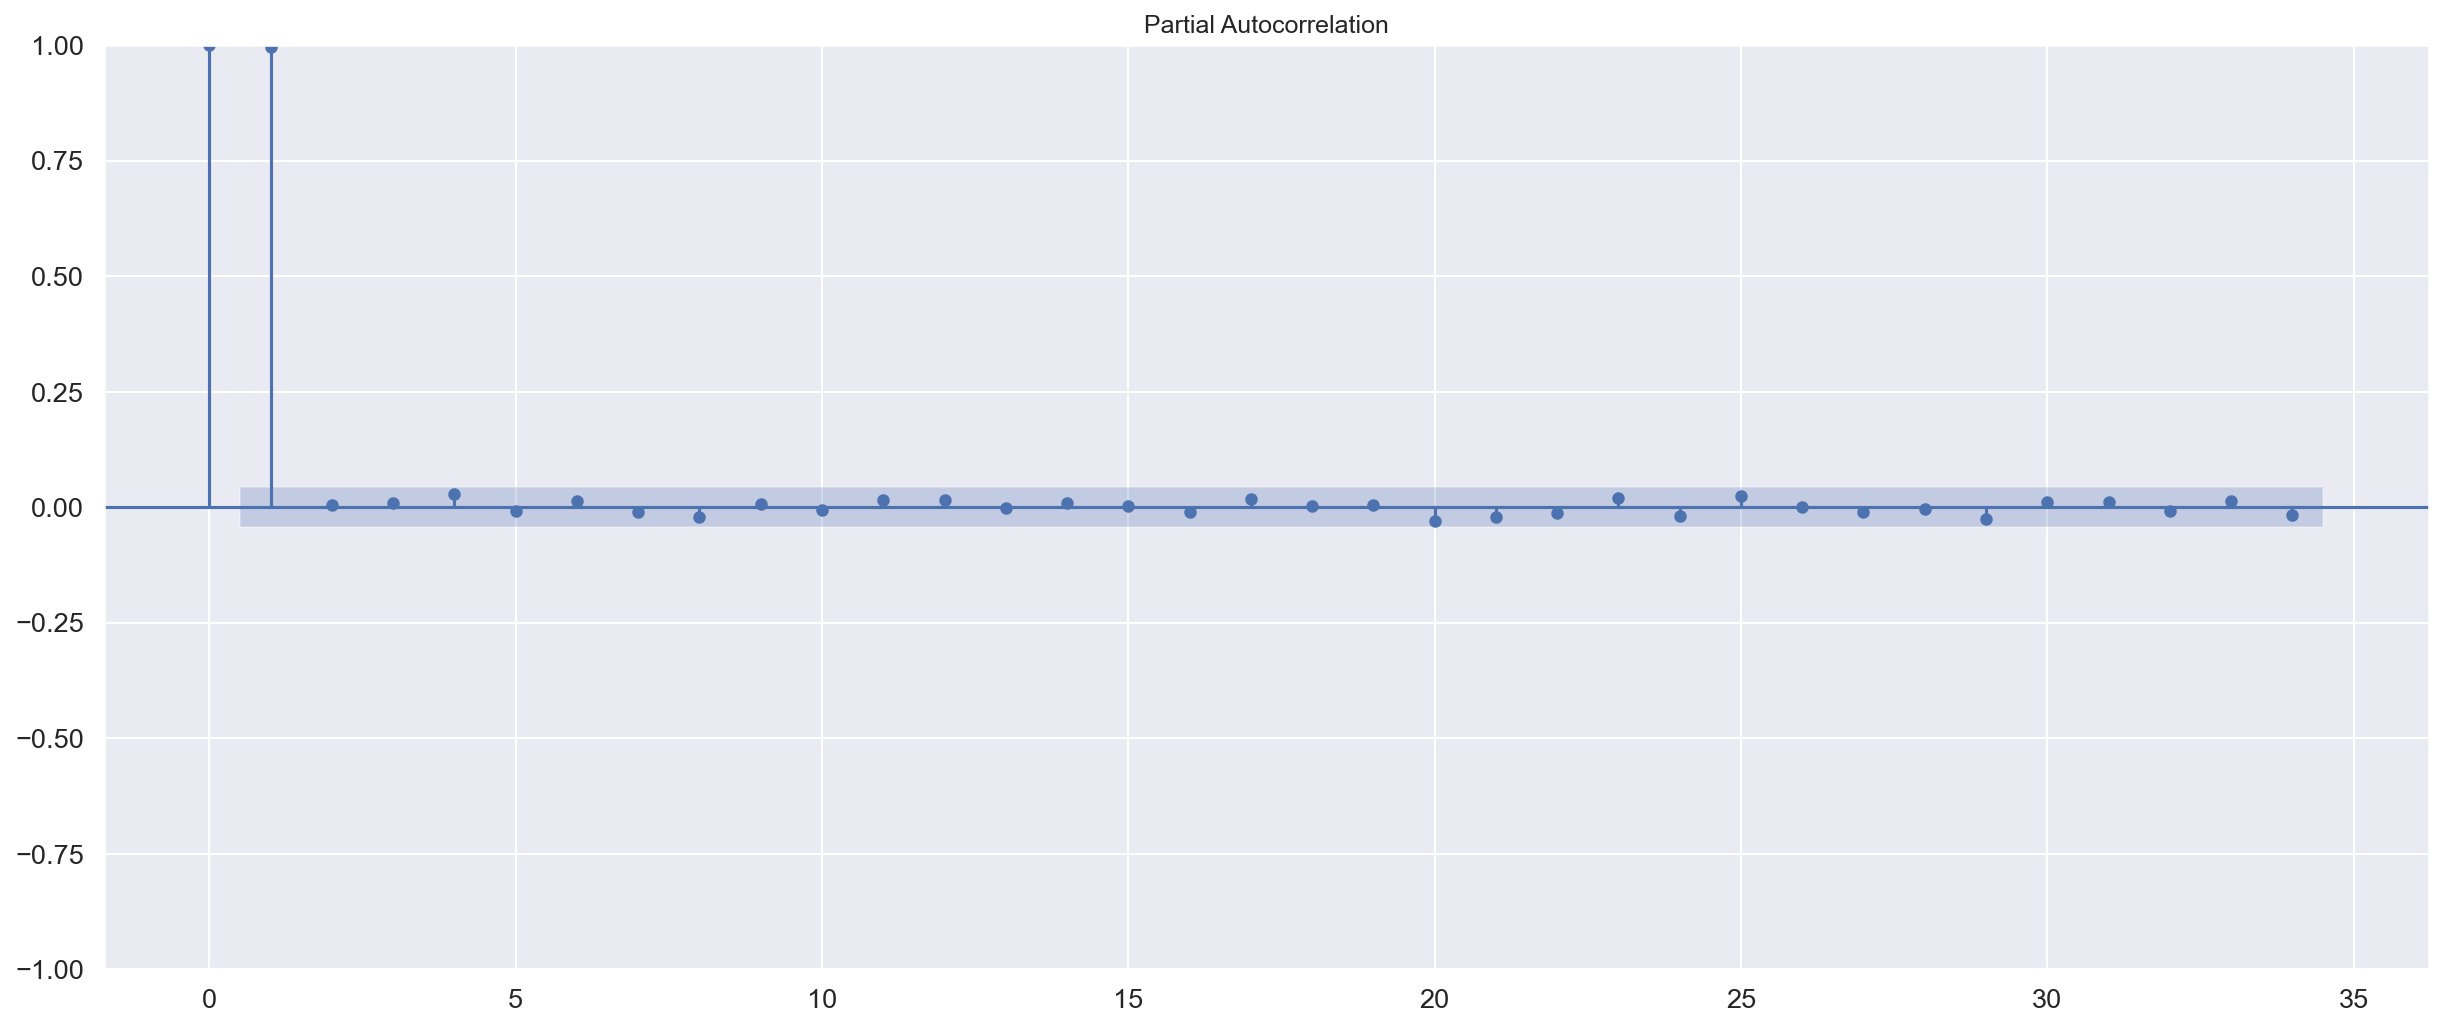

In [66]:
#Plot PACF

plot_pacf(df['Adj Close']);


# Splitting Data to Train and Test

In [74]:
train, test = df.iloc[:-30,:], df.iloc[-30:, :]
len(train), len(test)

(1980, 30)

In [79]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [80]:
train

Date    Open    High     Low   Close  Adj Close    Volume  \
0    2012-01-04   58.57   59.24   58.47   59.06      51.04  65005500   
1    2012-01-05   59.28   59.79   58.95   59.72      51.61  67817400   
2    2012-01-06   59.97   60.39   59.89   60.34      52.14  79573200   
3    2012-01-09   60.79   61.11   60.19   60.25      52.06  98506100   
4    2012-01-10   60.84   60.86   60.21   60.46      52.25  64549100   
...         ...     ...     ...     ...     ...        ...       ...   
1975 2019-11-08  258.69  260.44  256.85  260.14     258.36  17496600   
1976 2019-11-11  258.30  262.47  258.28  262.20     260.40  20455300   
1977 2019-11-12  261.55  262.79  260.92  261.96     260.17  21847200   
1978 2019-11-13  261.13  264.78  261.07  264.47     262.66  25683600   
1979 2019-11-14  263.75  264.88  262.10  262.64     260.84  22295700   

          Gain Month  Year Day  Adj Close_log  Adj Close_diff  
0     0.005318   Jan  2012  04       3.932610        0.005304  
1     0.011168   Jan  2012  05       3.943715        0.011106  
2     0.010269   Jan  2012  06       3.953932        0.010217  
3    -0.001534   Jan  2012  09       3.952397       -0.001536  
4     0.003650   Jan  2012  10       3.956040        0.003643  
...        ...   ...   ...  ..            ...             ...  
1975  0.002756   Nov  2019  08       5.554354        0.002752  
1976  0.007896   Nov  2019  11       5.562219        0.007865  
1977 -0.000883   Nov  2019  12       5.561335       -0.000884  
1978  0.009571   Nov  2019  13       5.570860        0.009525  
1979 -0.006929   Nov  2019  14       5.563907       -0.006953  

[1980 rows x 13 columns]

In [81]:
test

Date    Open    High     Low   Close  Adj Close    Volume      Gain  \
0  2019-11-15  263.68  265.78  263.01  265.76     263.94  25051600  0.011885   
1  2019-11-18  265.80  267.43  264.23  267.10     265.27  21675800  0.005039   
2  2019-11-19  267.90  268.00  265.39  266.29     264.47  19041800 -0.003016   
3  2019-11-20  265.54  266.08  260.40  263.19     261.39  26558600 -0.011646   
4  2019-11-21  263.69  264.01  261.18  262.01     260.21  30348800 -0.004514   
5  2019-11-22  262.59  263.18  260.84  261.78     259.99  16331300 -0.000845   
6  2019-11-25  262.71  266.44  262.52  266.37     264.54  21005100  0.017501   
7  2019-11-26  266.94  267.16  262.50  264.29     262.48  26301900 -0.007787   
8  2019-11-27  265.58  267.98  265.31  267.84     266.00  16308900  0.013411   
9  2019-11-29  266.60  268.00  265.90  267.25     265.42  11654400 -0.002180   
10 2019-12-02  267.27  268.25  263.45  264.16     262.35  23621800 -0.011567   
11 2019-12-03  258.31  259.53  256.29  259.45     257.67  28607600 -0.017839   
12 2019-12-04  261.07  263.31  260.68  261.74     259.95  16795400  0.008849   
13 2019-12-05  263.79  265.89  262.73  265.58     263.76  18606100  0.014657   
14 2019-12-06  267.48  271.00  267.30  270.71     268.86  26518900  0.019336   
15 2019-12-09  270.00  270.80  264.91  266.92     265.09  32010600 -0.014022   
16 2019-12-10  268.60  270.07  265.86  268.48     266.64  22605100  0.005847   
17 2019-12-11  268.81  271.10  268.50  270.77     268.91  19689200  0.008513   
18 2019-12-12  267.78  272.56  267.32  271.46     269.60  34327600  0.002566   
19 2019-12-13  271.46  275.30  270.93  275.15     273.26  33396900  0.013576   
20 2019-12-16  277.00  280.79  276.98  279.86     277.94  32046500  0.017127   
21 2019-12-17  279.57  281.77  278.80  280.41     278.49  28539600  0.001979   
22 2019-12-18  279.80  281.90  279.12  279.74     277.82  29007100 -0.002406   
23 2019-12-19  279.50  281.18  278.95  280.02     278.10  24592300  0.001008   
24 2019-12-20  282.23  282.65  278.56  279.44     277.53  68994500 -0.002050   
25 2019-12-23  280.53  284.25  280.37  284.00     282.05  24643000  0.016287   
26 2019-12-24  284.69  284.89  282.92  284.27     282.32  12119700  0.000957   
27 2019-12-26  284.82  289.98  284.70  289.91     287.92  23280300  0.019836   
28 2019-12-27  291.12  293.97  288.12  289.80     287.81  36566500 -0.000382   
29 2019-12-30  289.46  292.69  285.22  291.52     289.52  36028600  0.005941   

   Month  Year Day  Adj Close_log  Adj Close_diff  
0    Nov  2019  15       5.575722        0.011815  
1    Nov  2019  18       5.580748        0.005026  
2    Nov  2019  19       5.577728       -0.003020  
3    Nov  2019  20       5.566014       -0.011714  
4    Nov  2019  21       5.561489       -0.004525  
5    Nov  2019  22       5.560643       -0.000846  
6    Nov  2019  25       5.577992        0.017349  
7    Nov  2019  26       5.570175       -0.007818  
8    Nov  2019  27       5.583496        0.013321  
9    Nov  2019  29       5.581313       -0.002183  
10   Dec  2019  02       5.569679       -0.011634  
11   Dec  2019  03       5.551680       -0.018000  
12   Dec  2019  04       5.560489        0.008810  
13   Dec  2019  05       5.575040        0.014550  
14   Dec  2019  06       5.594191        0.019151  
15   Dec  2019  09       5.580069       -0.014121  
16   Dec  2019  10       5.585899        0.005830  
17   Dec  2019  11       5.594377        0.008477  
18   Dec  2019  12       5.596939        0.002563  
19   Dec  2019  13       5.610424        0.013484  
20   Dec  2019  16       5.627405        0.016982  
21   Dec  2019  17       5.629382        0.001977  
22   Dec  2019  18       5.626973       -0.002409  
23   Dec  2019  19       5.627981        0.001007  
24   Dec  2019  20       5.625929       -0.002052  
25   Dec  2019  23       5.642084        0.016155  
26   Dec  2019  24       5.643041        0.000957  
27   Dec  2019  26       5.662683        0.019641  
28   Dec  2019  27  

In [96]:
arima111 = ARIMA(train['Adj Close'], order=(1,1,1)).fit()
pred111_trn = arima111.predict(start=train.index[0],end=train.index[-1])
pred111_tst = arima111.predict(start=train.index[-1]+1,end=train.index[-1]+30)

In [98]:
# A1_rmse_tr = sqrt(mean_squared_error(train, predictions1_trn))
# print('Train RMSE: %.3f' % A1_rmse_tr)
# A1_rmse_ts = sqrt(mean_squared_error(test, predictions1_tst))
# print('Test RMSE: %.3f' % A1_rmse_ts)

In [218]:
A111_rmse_tr = mean_squared_error(train["Adj Close"], pred111_trn)**0.5
print('Train RMSE: %.3f' % A111_rmse_tr)
A111_rmse_ts = mean_squared_error(test["Adj Close"], pred111_tst)**0.5
print('Test RMSE: %.3f' % A111_rmse_ts)

Train RMSE: 2.318
Test RMSE: 13.238


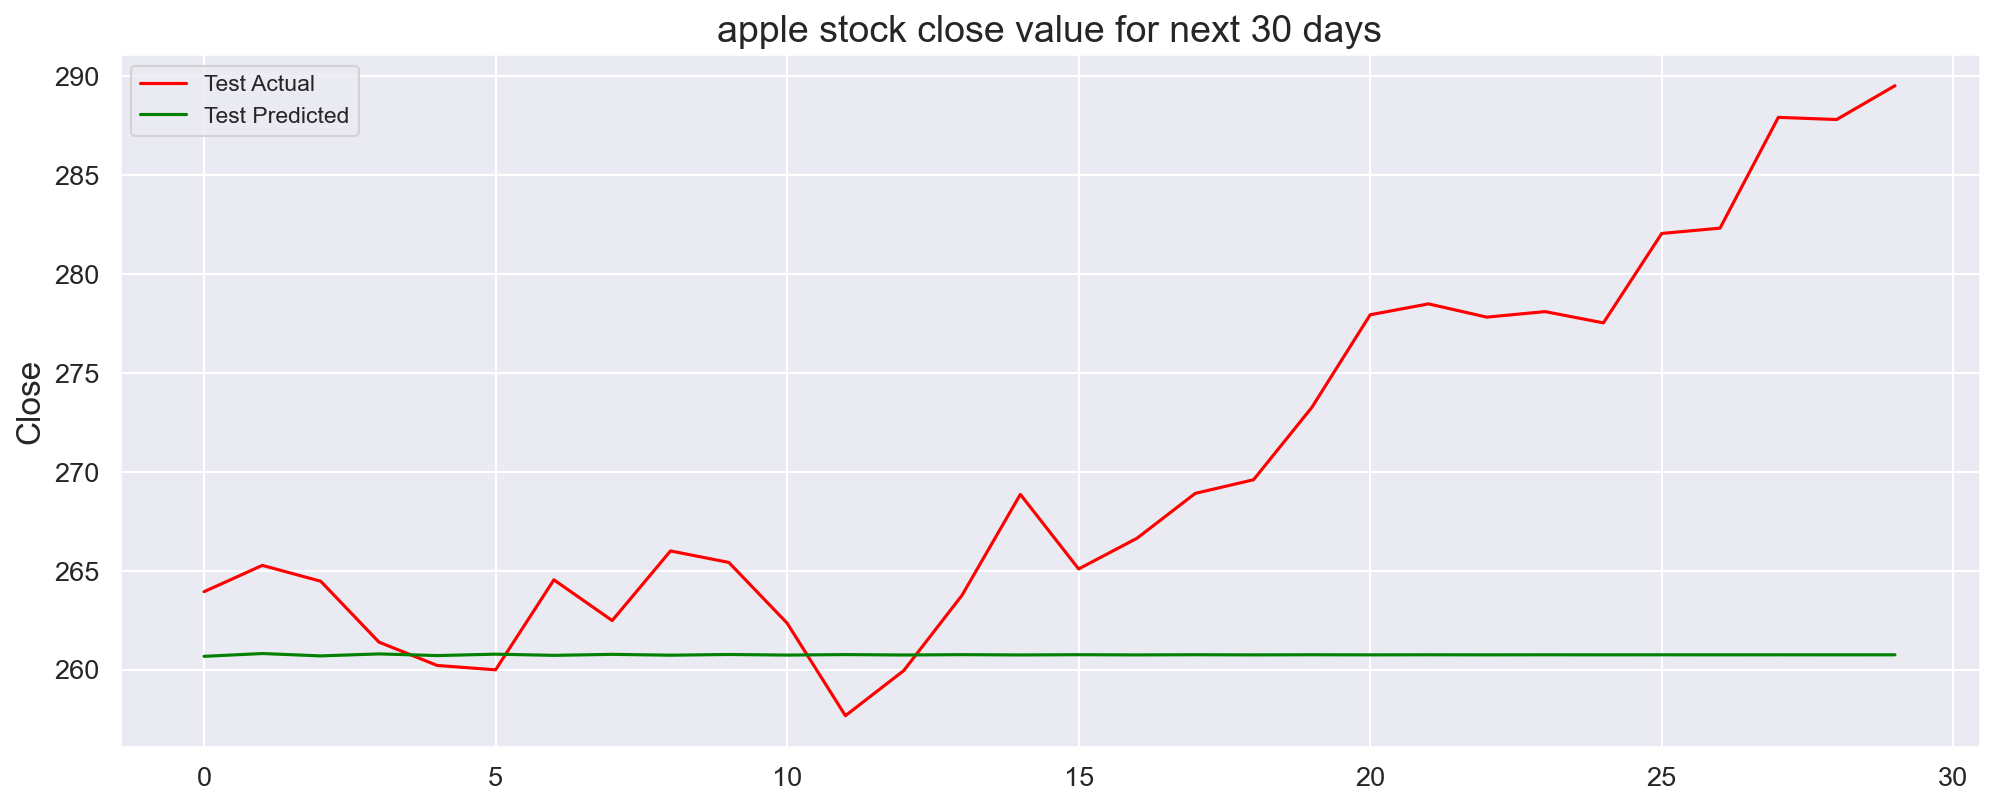

In [165]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test["Adj Close"], label="Test Actual", color='red')
plt.plot(test.index, pred111_tst,  label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [114]:
arima221 = ARIMA(train["Adj Close"], order=(2,1,1)).fit()
pred221_trn = arima221.predict(start = train.index[0],end = train.index[-1])
pred221_tst = arima221.predict(start = train.index[-1]+1,end = train.index[-1]+30)

In [115]:
# A2_rmse_tr = sqrt(mean_squared_error(train, predictions2_trn))
# print('Train RMSE: %.3f' % A2_rmse_tr)
# A2_rmse_ts = sqrt(mean_squared_error(test, predictions2_tst))
# print('Test RMSE: %.3f' % A2_rmse_ts)

In [217]:
A221_rmse_tr = mean_squared_error(train["Adj Close"], pred221_trn)**0.5
print('Train RMSE: %.3f' % A221_rmse_tr)
A221_rmse_ts = mean_squared_error(test["Adj Close"], pred221_tst)**0.5
print('Test RMSE: %.3f' % A221_rmse_ts)

Train RMSE: 2.317
Test RMSE: 13.216


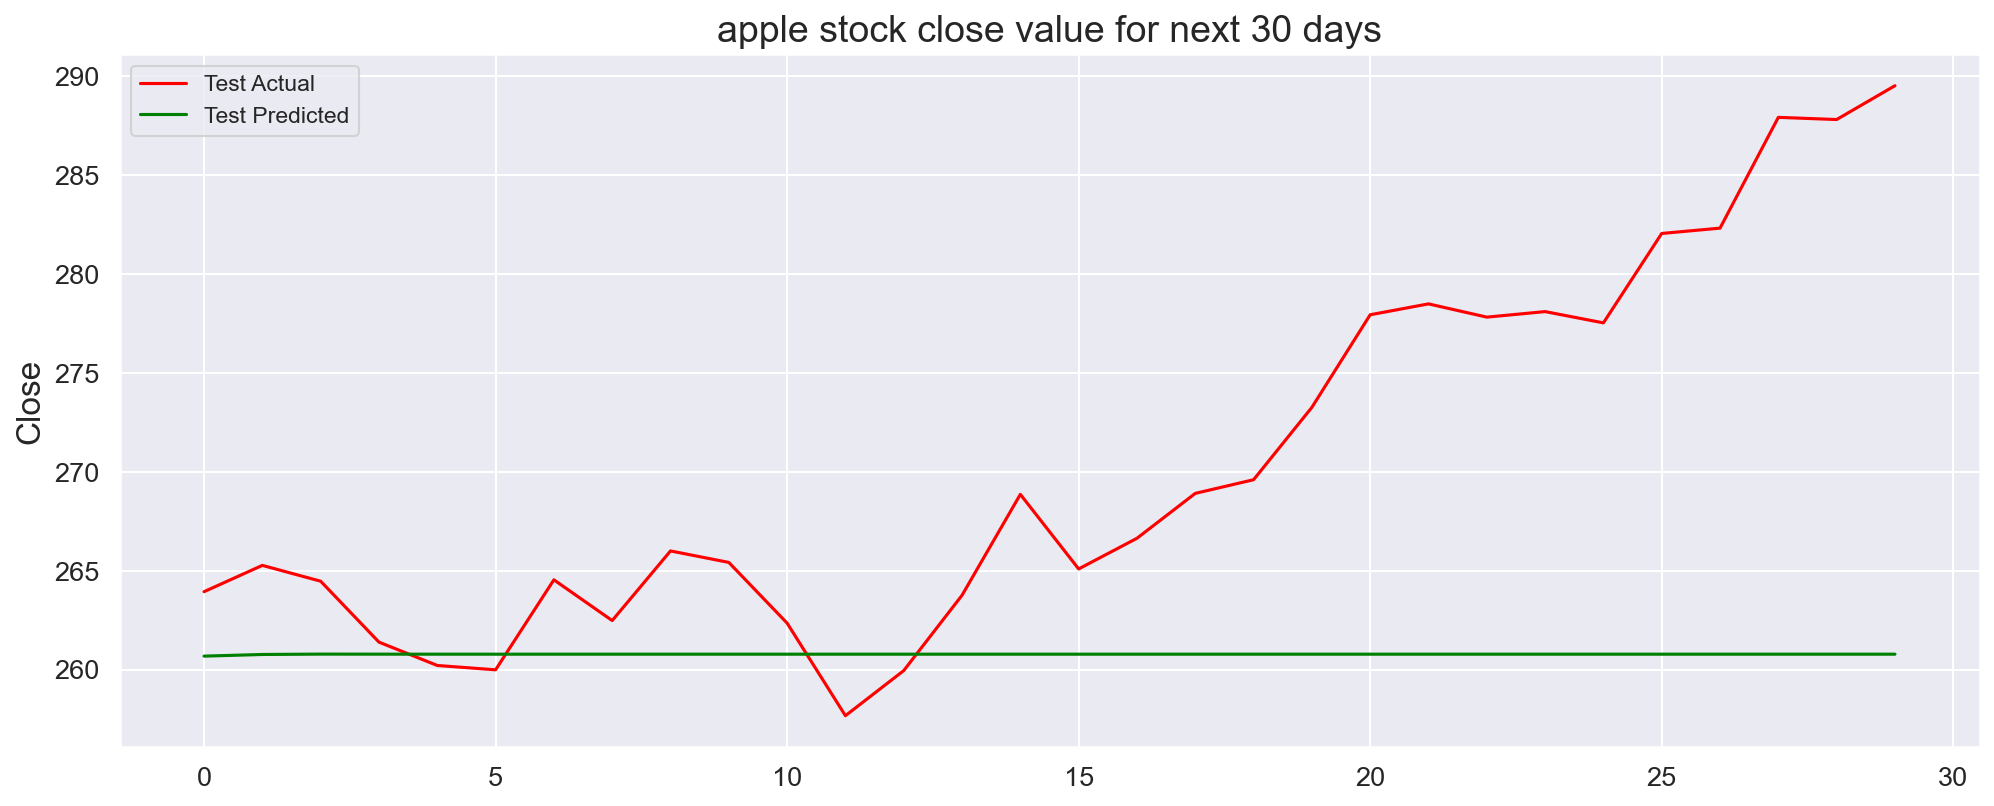

In [164]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Test Actual", color='red')
plt.plot(test.index, pred221_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [121]:
arima717 = ARIMA(train['Adj Close'], order=(7,1,7)).fit()
pred717_trn = arima717.predict(start = train.index[0], end = train.index[-1])
pred717_tst = arima717.predict(start = train.index[-1]+1, end = train.index[-1]+30)

In [47]:
# A3_rmse_tr = mean_squared_error(train['Adj Close'], pred717_trn)**0.5
# print('Train RMSE: %.3f' % A3_rmse_tr)
# A3_rmse_ts = mean_squared_error(test['Adj Close'], pred717_tst)**0.5
# print('Test RMSE: %.3f' % A3_rmse_ts)

Train RMSE: 1.918
Test RMSE: 31.724


In [216]:
A717_rmse_tr = mean_squared_error(train['Adj Close'], pred717_trn)**0.5
print('Train RMSE: %.3f' % A717_rmse_tr)
A717_rmse_ts = mean_squared_error(test['Adj Close'], pred717_tst)**0.5
print('Test RMSE: %.3f' % A717_rmse_ts)

Train RMSE: 2.298
Test RMSE: 9.460


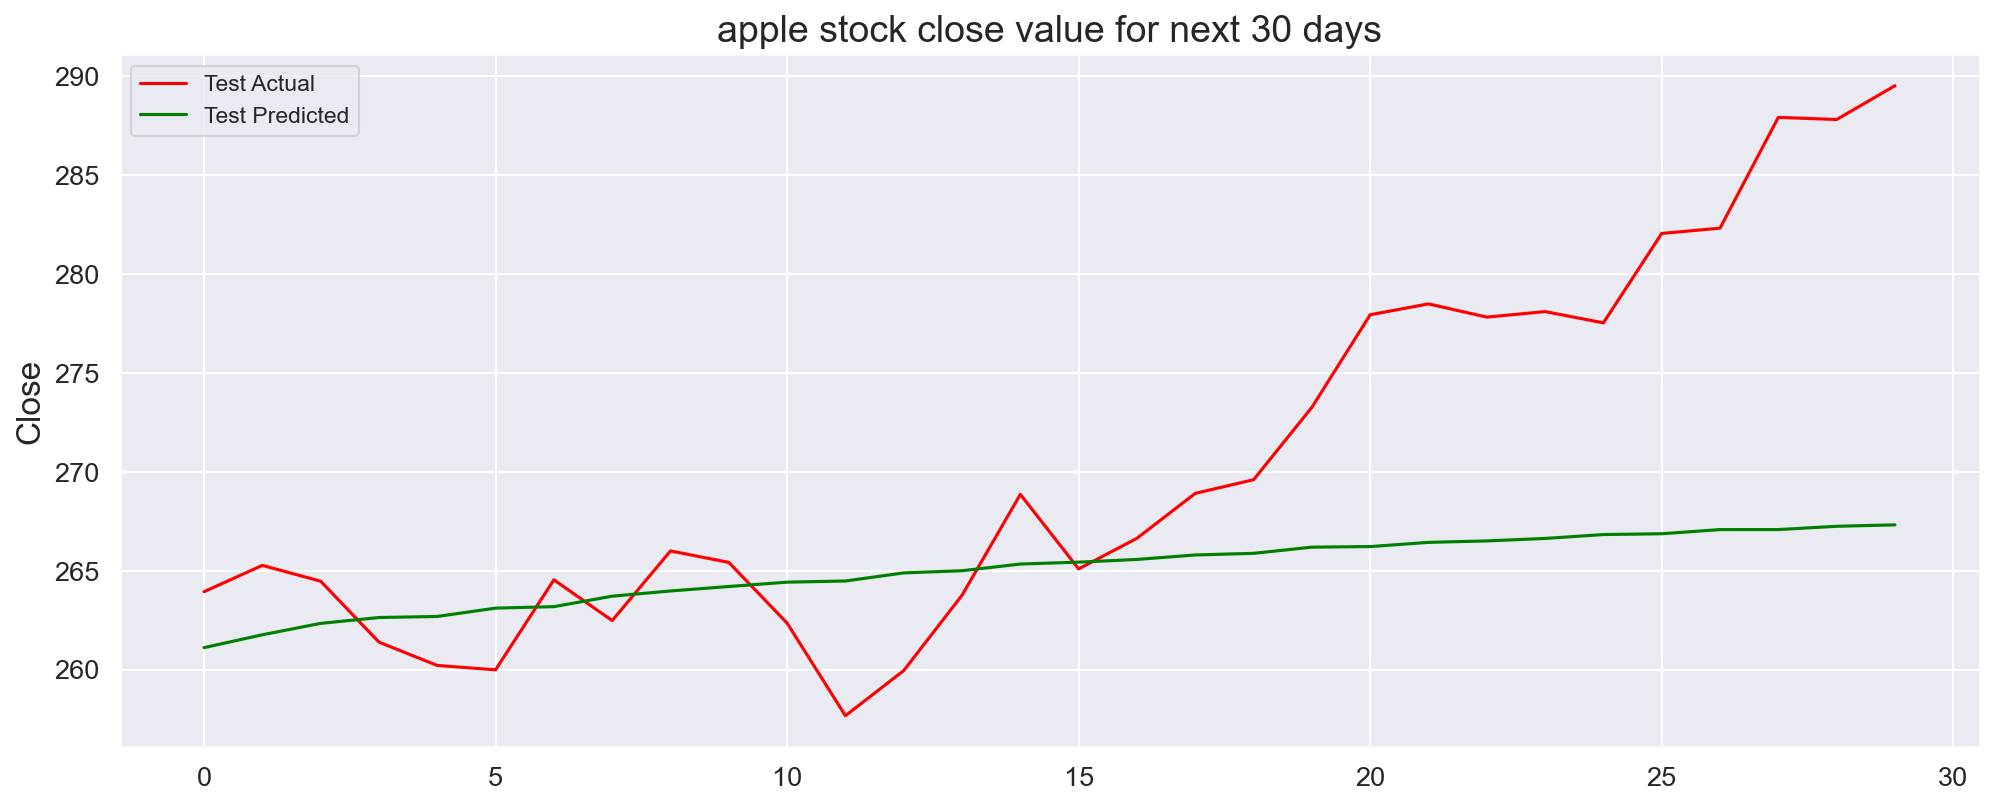

In [163]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Test Actual", color='red')
plt.plot(test.index, pred717_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [126]:
arima718 = ARIMA(train['Adj Close'], order=(7,1,8)).fit()
pred718_trn = arima718.predict(start = train.index[0],end = train.index[-1])
pred718_tst = arima718.predict(start = train.index[-1]+1,end = train.index[-1]+30)

In [51]:
# A4_rmse_tr = sqrt(mean_squared_error(train, predictions4_trn))
# print('Train RMSE: %.3f' % A4_rmse_tr)
# A4_rmse_ts = sqrt(mean_squared_error(test, predictions4_tst))
# print('Test RMSE: %.3f' % A4_rmse_ts)

Train RMSE: 1.918
Test RMSE: 42.351


In [215]:
A718_rmse_tr = mean_squared_error(train['Adj Close'], pred718_trn)**0.5
print('Train RMSE: %.3f' % A718_rmse_tr)
A718_rmse_ts = mean_squared_error(test['Adj Close'], pred718_tst)**0.5
print('Test RMSE: %.3f' % A718_rmse_ts)

Train RMSE: 2.299
Test RMSE: 10.419


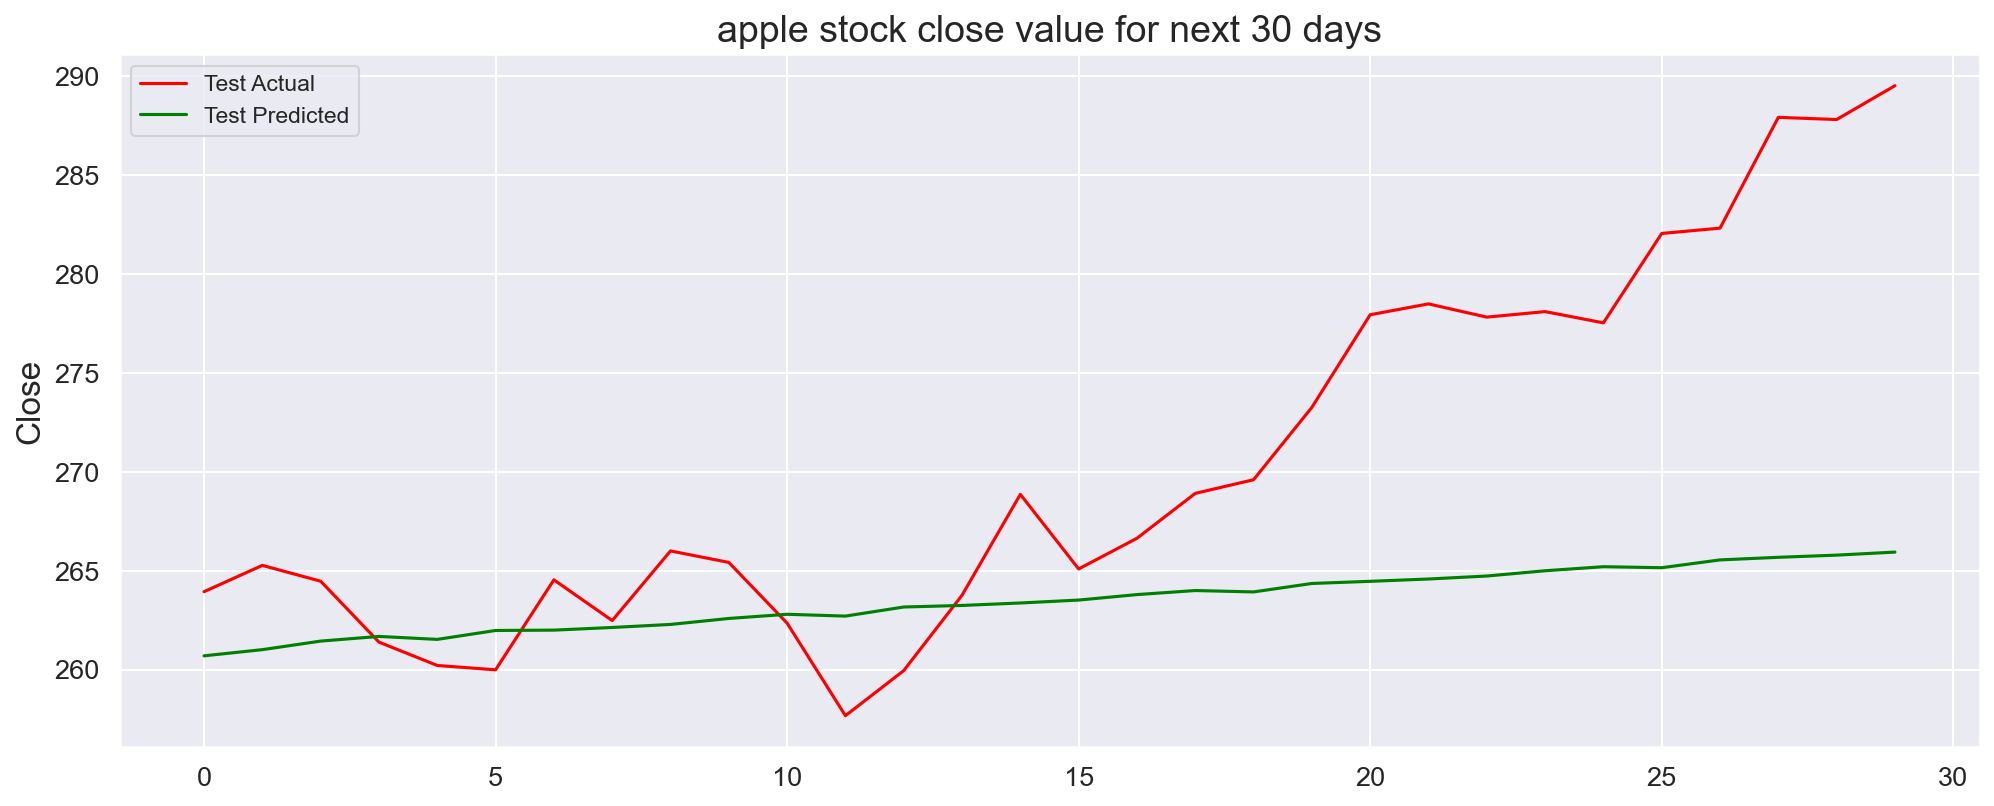

In [162]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Test Actual", color='red')
plt.plot(test.index, pred718_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [131]:
# plt.figure(figsize=(16,6))
# plt.plot(test, label="Test Actual", color='red')
# plt.plot(predictions4_tst, label="Test Predicted", color='green')
# plt.title('apple stock close value', fontsize=18)
# plt.ylabel('Close', fontsize=16)
# plt.legend()

In [133]:
arima817 = ARIMA(train['Adj Close'], order=(8,1,7)).fit()
pred817_trn = arima817.predict(start = train.index[0],end = train.index[-1])
pred817_tst = arima817.predict(start = train.index[-1]+1, end = train.index[-1]+30)

In [55]:
# A5_rmse_tr = sqrt(mean_squared_error(train, pred817_trn))
# print('Train RMSE: %.3f' % A5_rmse_tr)
# A5_rmse_ts = sqrt(mean_squared_error(test, pred817_tst))
# print('Test RMSE: %.3f' % A5_rmse_ts)

Train RMSE: 1.917
Test RMSE: 24.093


In [214]:
A817_rmse_tr = mean_squared_error(train['Adj Close'], pred817_trn)**0.5
print('Train RMSE: %.3f' % A817_rmse_tr)
A817_rmse_ts = mean_squared_error(test['Adj Close'], pred817_tst)**0.5
print('Test RMSE: %.3f' % A817_rmse_ts)

Train RMSE: 2.297
Test RMSE: 9.992


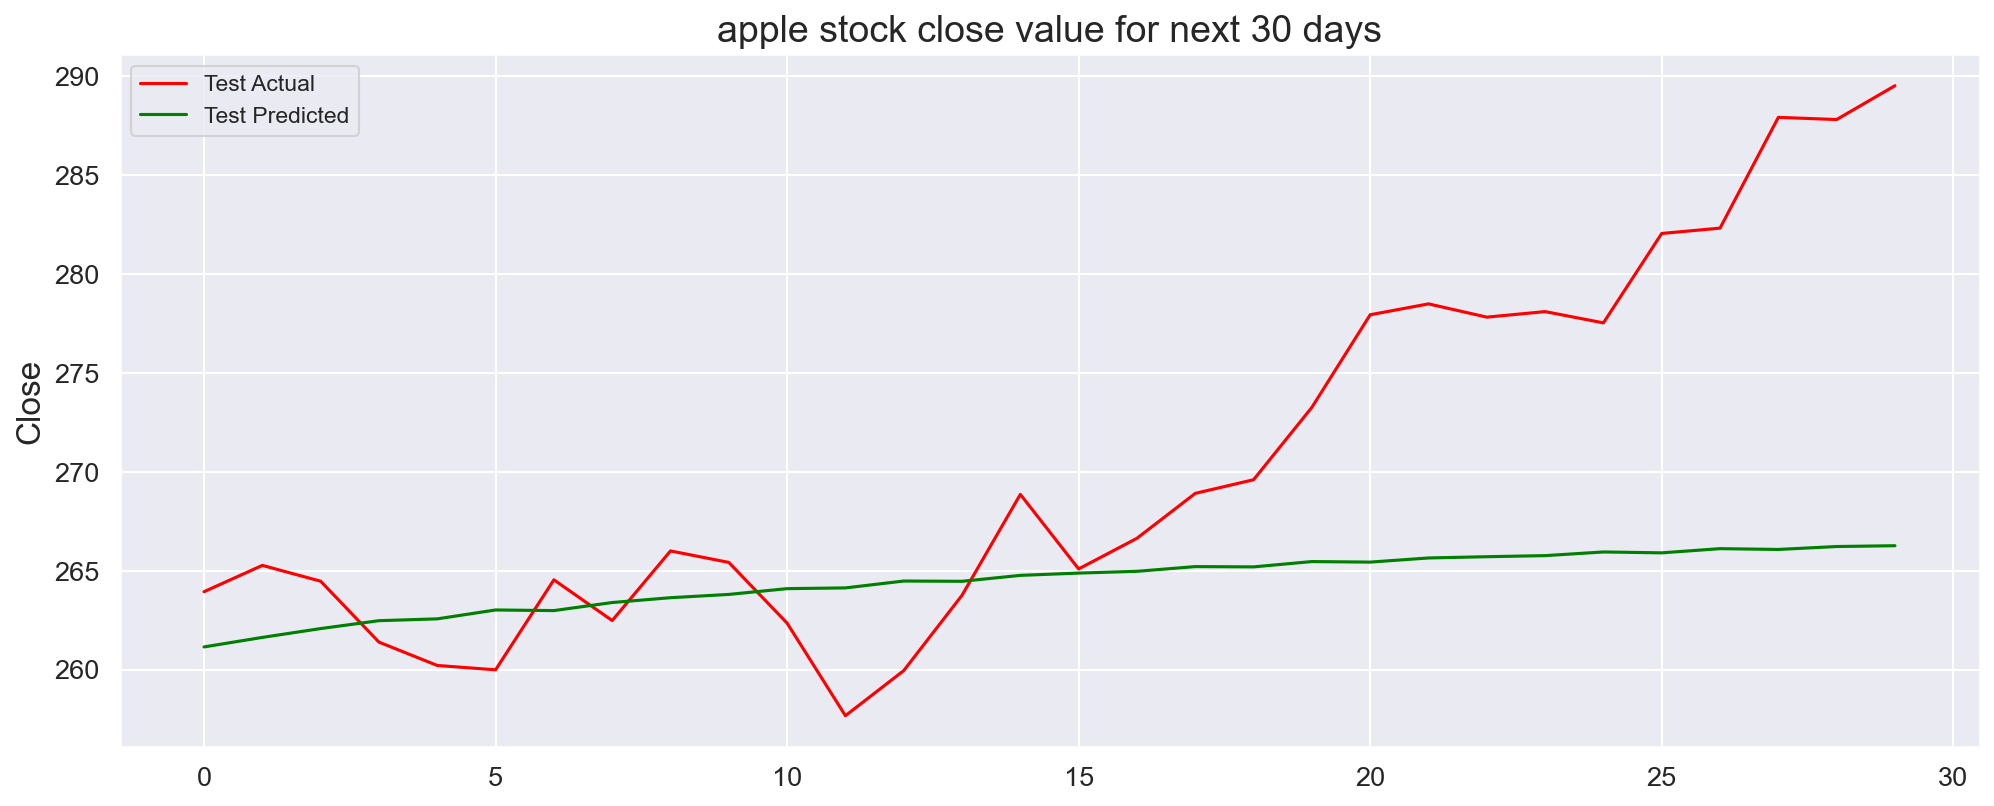

In [161]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Test Actual", color='red')
plt.plot(test.index, pred817_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [139]:
arima818 = ARIMA(train['Adj Close'], order=(8,1,8)).fit()
pred818_trn = arima818.predict(start = train.index[0],end = train.index[-1])
pred818_tst = arima818.predict(start = train.index[-1]+1,end = train.index[-1]+30)

In [59]:
# A6_rmse_tr = sqrt(mean_squared_error(train, predictions6_trn))
# print('Train RMSE: %.3f' % A6_rmse_tr)
# A6_rmse_ts = sqrt(mean_squared_error(test, predictions6_tst))
# print('Test RMSE: %.3f' % A6_rmse_ts)

Train RMSE: 1.917
Test RMSE: 25.466


In [213]:
A818_rmse_tr = mean_squared_error(train['Adj Close'], pred818_trn)**0.5
print('Train RMSE: %.3f' % A818_rmse_tr)
A818_rmse_ts = mean_squared_error(test['Adj Close'], pred818_tst)**0.5
print('Test RMSE: %.3f' % A818_rmse_ts)

Train RMSE: 2.297
Test RMSE: 10.206


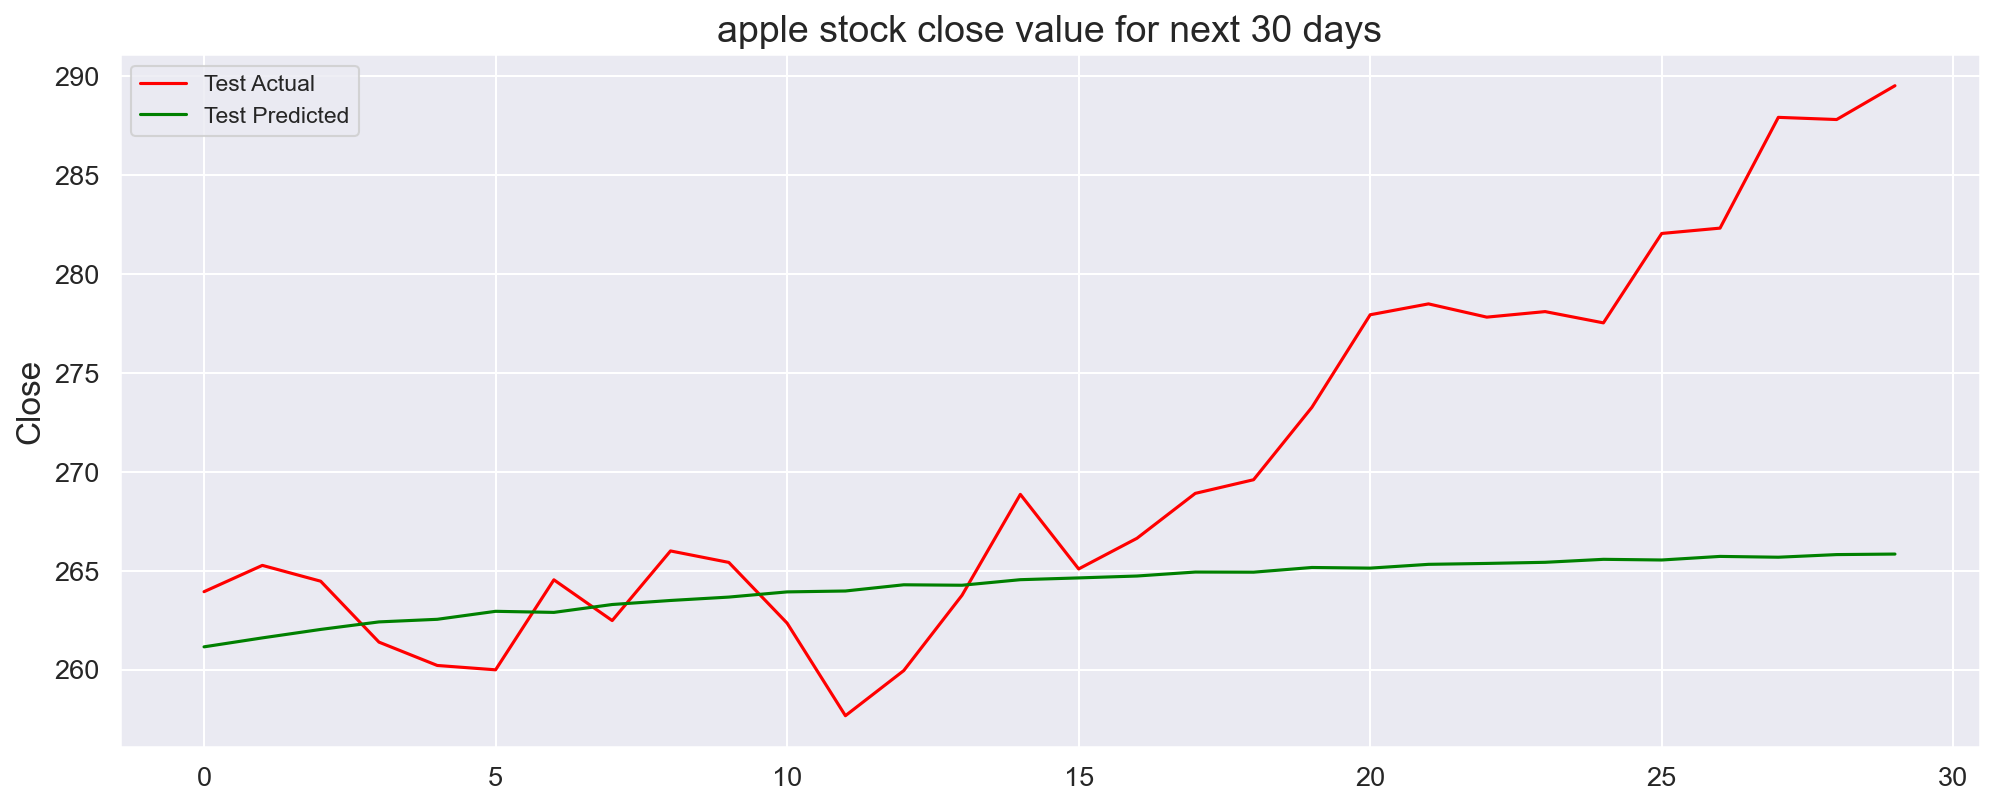

In [160]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test["Adj Close"], label="Test Actual", color='red')
plt.plot(test.index, pred818_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Close', fontsize=16)
plt.legend()

In [143]:
# plt.figure(figsize=(16,6))
# plt.plot(test, label="Test Actual", color='red')
# plt.plot(predictions6_tst, label="Test Predicted", color='green')
# plt.title('apple stock close value', fontsize=18)
# plt.ylabel('Close', fontsize=16)
# plt.legend()

# SARIMA MODEL

In [63]:
df=pd.read_csv("AAPL.csv")

In [147]:
sarima11021 = SARIMAX(train['Adj Close'], 
                 order=(1,1,0),
                seasonal_order=(1,1,0,21)).fit()
# res=sarima.fit()
spred11021_trn = sarima11021.predict(start = train.index[0], end = train.index[-1])
spred11021_tst = sarima11021.predict(start = train.index[-1]+1, end = train.index[-1]+30)


In [148]:
sarima11021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1980
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 21)   Log Likelihood               -4512.334
Date:                            Tue, 30 May 2023   AIC                           9030.667
Time:                                    19:32:21   BIC                           9047.406
Sample:                                         0   HQIC                          9036.820
                                           - 1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0167      0.017      0.996      0.319      -0.016       0.050
ar.S.L21      -0.4986      0.012    -40.095      0.000      -0.523      -0.474
sigma2         5.8602      0.094     62.536      0.000       5.677       6.044
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2956.12
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               5.64   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [212]:
SA11011021_rmse_tr = mean_squared_error(train['Adj Close'], spred11021_trn)**0.5
print('Train RMSE: %.3f' % SA11011021_rmse_tr)
SA11011021_rmse_ts = mean_squared_error(test['Adj Close'], spred11021_tst)**0.5
print('Test RMSE: %.3f' % SA11011021_rmse_ts)

Train RMSE: 2.727
Test RMSE: 7.616


In [150]:
# SA_rmse_tr = sqrt(mean_squared_error(train, spredictions_trn))
# print('Train RMSE: %.3f' % SA_rmse_tr)
# SA_rmse_ts = sqrt(mean_squared_error(test, spredictions_tst))
# print('Test RMSE: %.3f' % SA_rmse_ts)

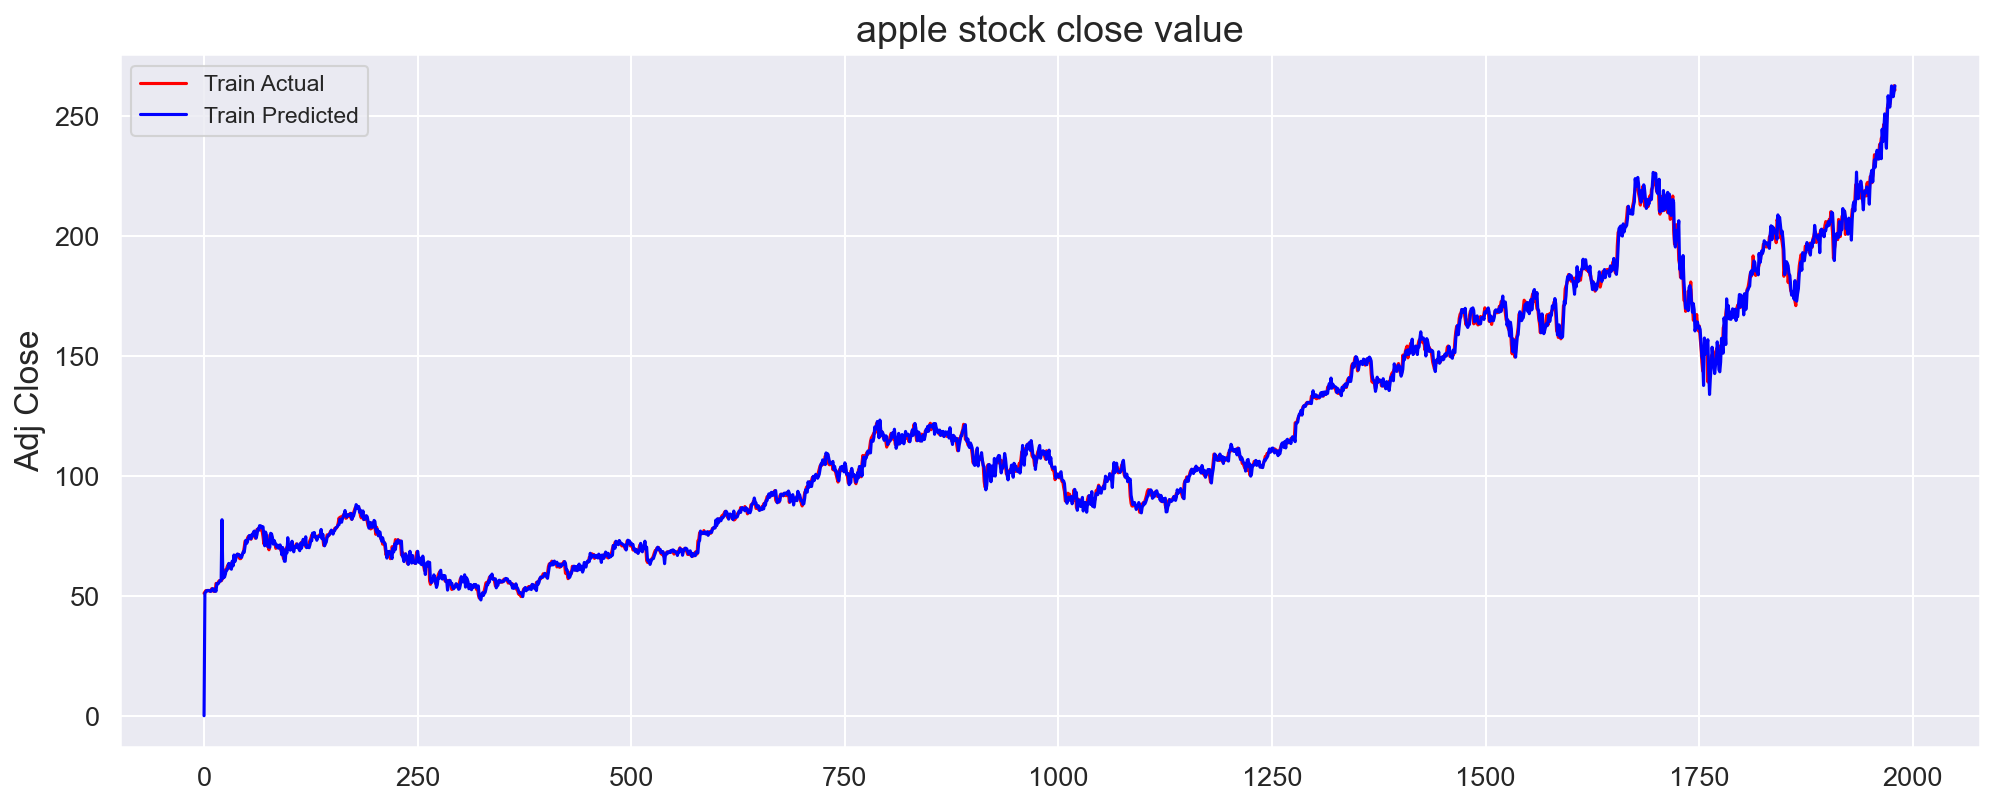

In [157]:
plt.figure(figsize=(16,6))
plt.plot(train["Adj Close"], label="Train Actual", color='red')
plt.plot(spred11021_trn, label="Train Predicted", color='blue')
plt.title('apple stock close value', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

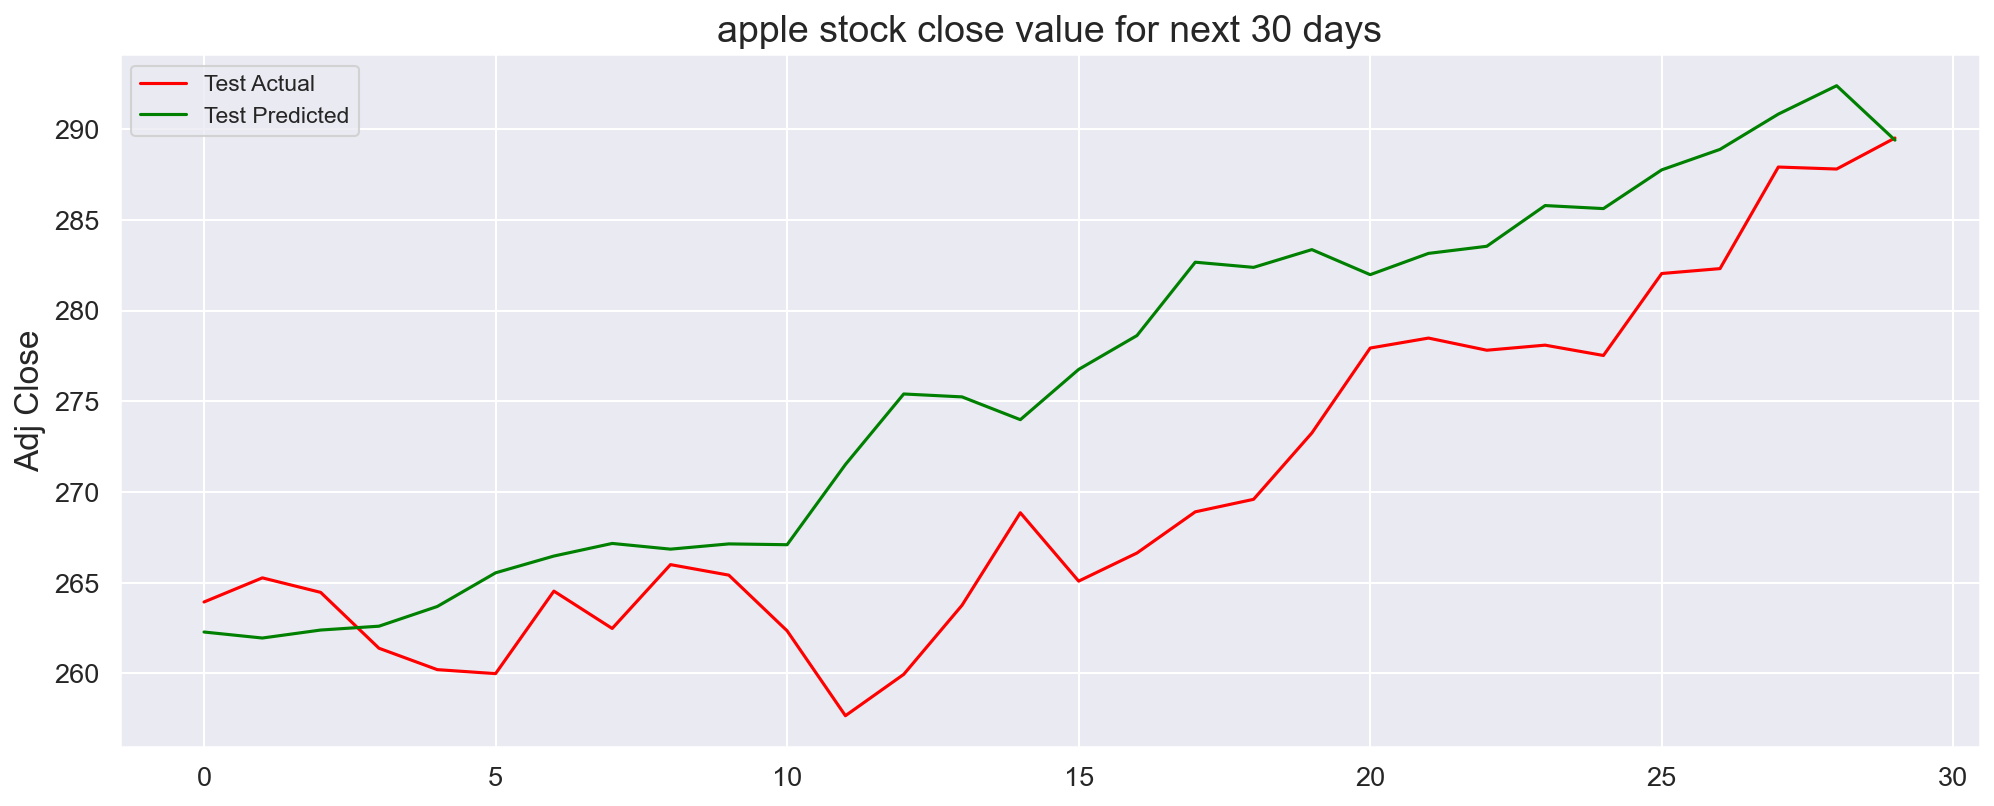

In [159]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Test Actual", color='red')
plt.plot(test.index, spred11021_tst, label="Test Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

In [167]:
sarima21011021 = SARIMAX(train['Adj Close'], 
                 order=(2,1,0),
                seasonal_order=(1,1,0,21)).fit()
spred21011021_trn = sarima21011021.predict(start = train.index[0],end = train.index[-1])
spred21011021_tst = sarima21011021.predict(start = train.index[-1]+1,end = train.index[-1]+30)

In [168]:
sarima21011021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1980
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 21)   Log Likelihood               -4507.938
Date:                            Wed, 31 May 2023   AIC                           9023.876
Time:                                    12:20:45   BIC                           9046.194
Sample:                                         0   HQIC                          9032.079
                                           - 1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0178      0.017      1.069      0.285      -0.015       0.050
ar.L2         -0.0669      0.015     -4.319      0.000      -0.097      -0.037
ar.S.L21      -0.4970      0.012    -39.781      0.000      -0.521      -0.472
sigma2         5.8340      0.095     61.420      0.000       5.648       6.020
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2831.61
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.59   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
# SA_rmse_tr = mean_squared_error(train, spred21011021_trn)**0.5
# print('Train RMSE: %.3f' % SA_rmse_tr)
# SA_rmse_ts = mean_squared_error(test, spred21011021_tst)**0.5
# print('Test RMSE: %.3f' % SA_rmse_ts)

Train RMSE: 2.284
Test RMSE: 23.940


In [219]:
SA21011021_rmse_tr = mean_squared_error(train['Adj Close'], spred21011021_trn)**0.5
print('Train RMSE: %.3f' % SA21011021_rmse_tr)
SA21011021_rmse_ts = mean_squared_error(test['Adj Close'], spred21011021_tst)**0.5
print('Test RMSE: %.3f' % SA21011021_rmse_ts)

Train RMSE: 2.722
Test RMSE: 7.611


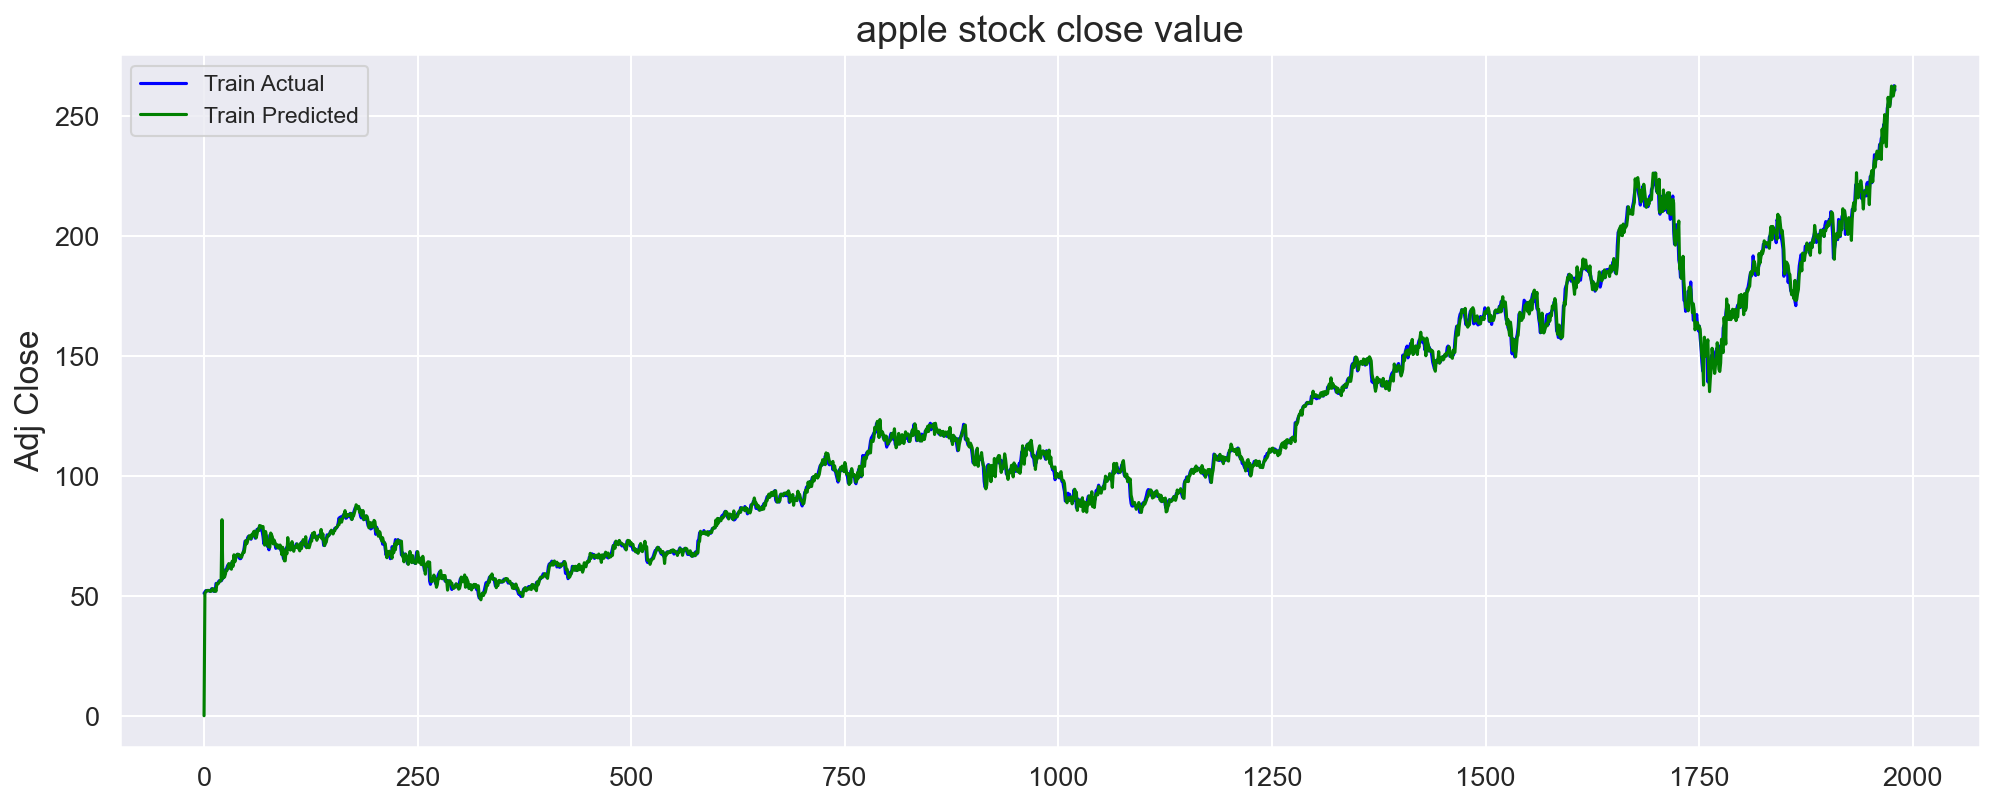

In [171]:
plt.figure(figsize=(16,6))
plt.plot(train['Adj Close'], label="Train Actual", color='blue')
plt.plot(spred21011021_trn, label="Train Predicted", color='green')
plt.title('apple stock close value', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

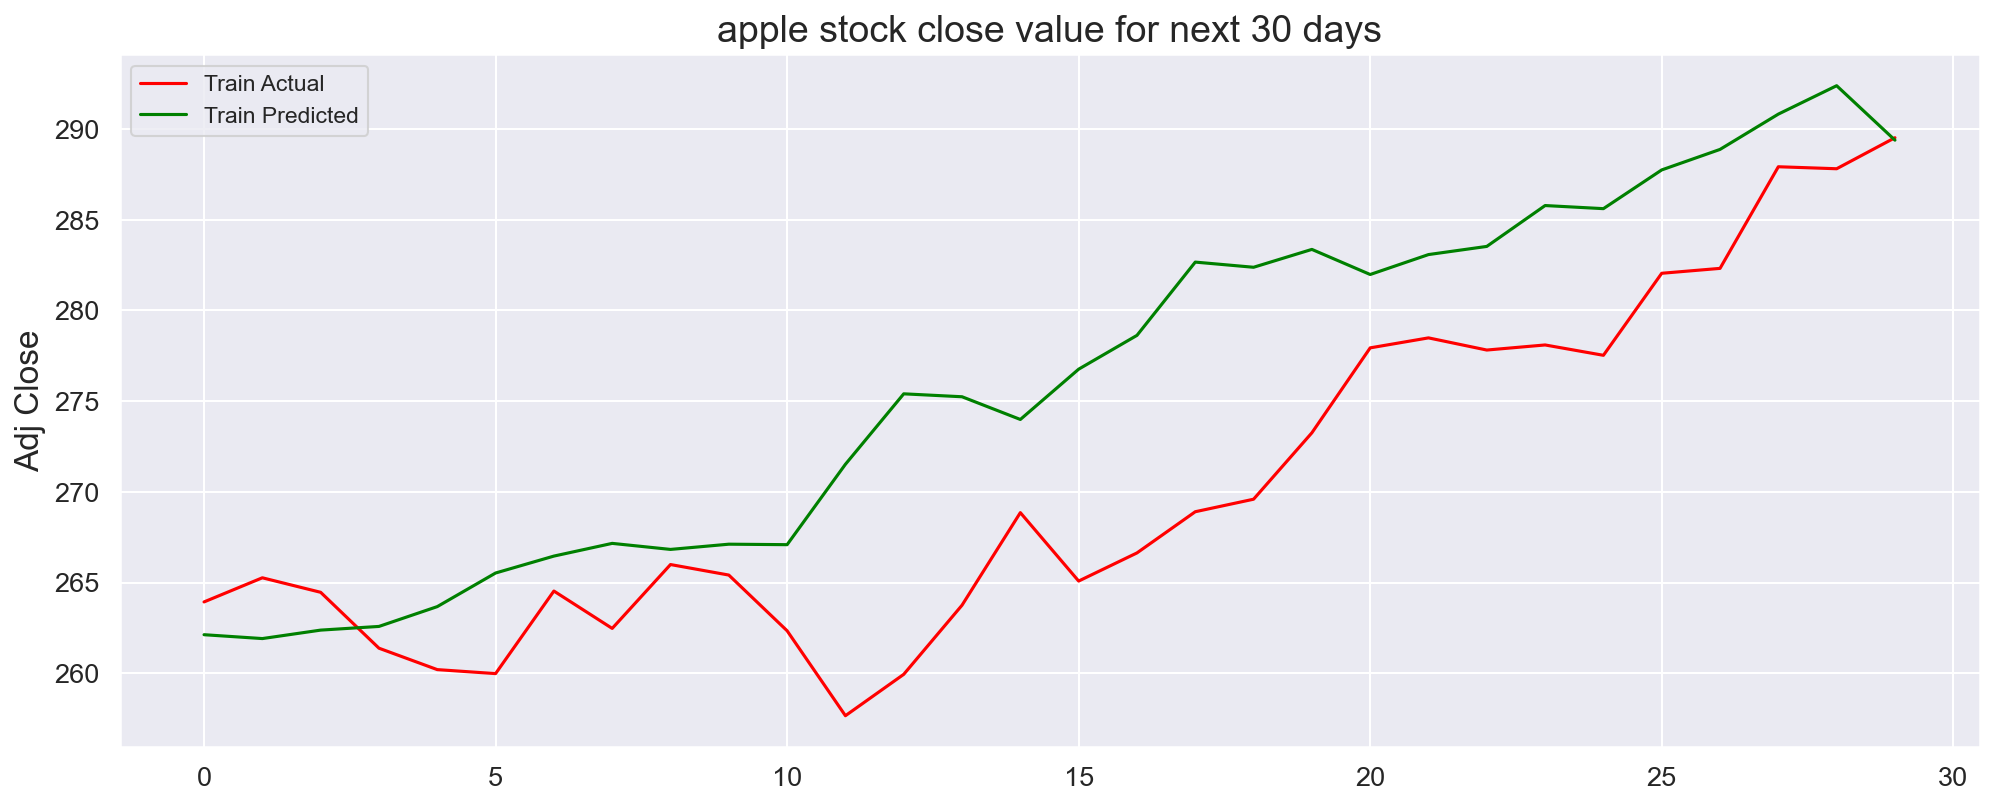

In [172]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Train Actual", color='red')
plt.plot(test.index, spred21011021_tst, label="Train Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

In [175]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima21021021 = SARIMAX(train['Adj Close'], 
                 order=(2,1,0),
                seasonal_order=(2,1,0,21)).fit()
spred21021021_trn = sarima21021021.predict(start = train.index[0], end = train.index[-1])
spred21021021_tst = sarima21021021.predict(start = train.index[-1]+1, end = train.index[-1]+30)

In [177]:
sarima21021021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1980
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 21)   Log Likelihood               -4397.239
Date:                            Wed, 31 May 2023   AIC                           8804.478
Time:                                    12:29:05   BIC                           8832.376
Sample:                                         0   HQIC                          8814.732
                                           - 1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0158      0.016      0.982      0.326      -0.016       0.047
ar.L2         -0.0603      0.016     -3.786      0.000      -0.092      -0.029
ar.S.L21      -0.6634      0.015    -44.988      0.000      -0.692      -0.634
ar.S.L42      -0.3321      0.014    -23.153      0.000      -0.360      -0.304
sigma2         5.1972      0.084     62.069      0.000       5.033       5.361
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3003.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.87   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
SA21021021_rmse_tr = mean_squared_error(train['Adj Close'], spred21021021_trn)**0.5
print('Train RMSE: %.3f' % SA21021021_rmse_tr)
SA21021021_rmse_ts = mean_squared_error(test['Adj Close'], spred21021021_tst)**0.5
print('Test RMSE: %.3f' % SA21021021_rmse_ts)

Train RMSE: 2.605
Test RMSE: 5.896


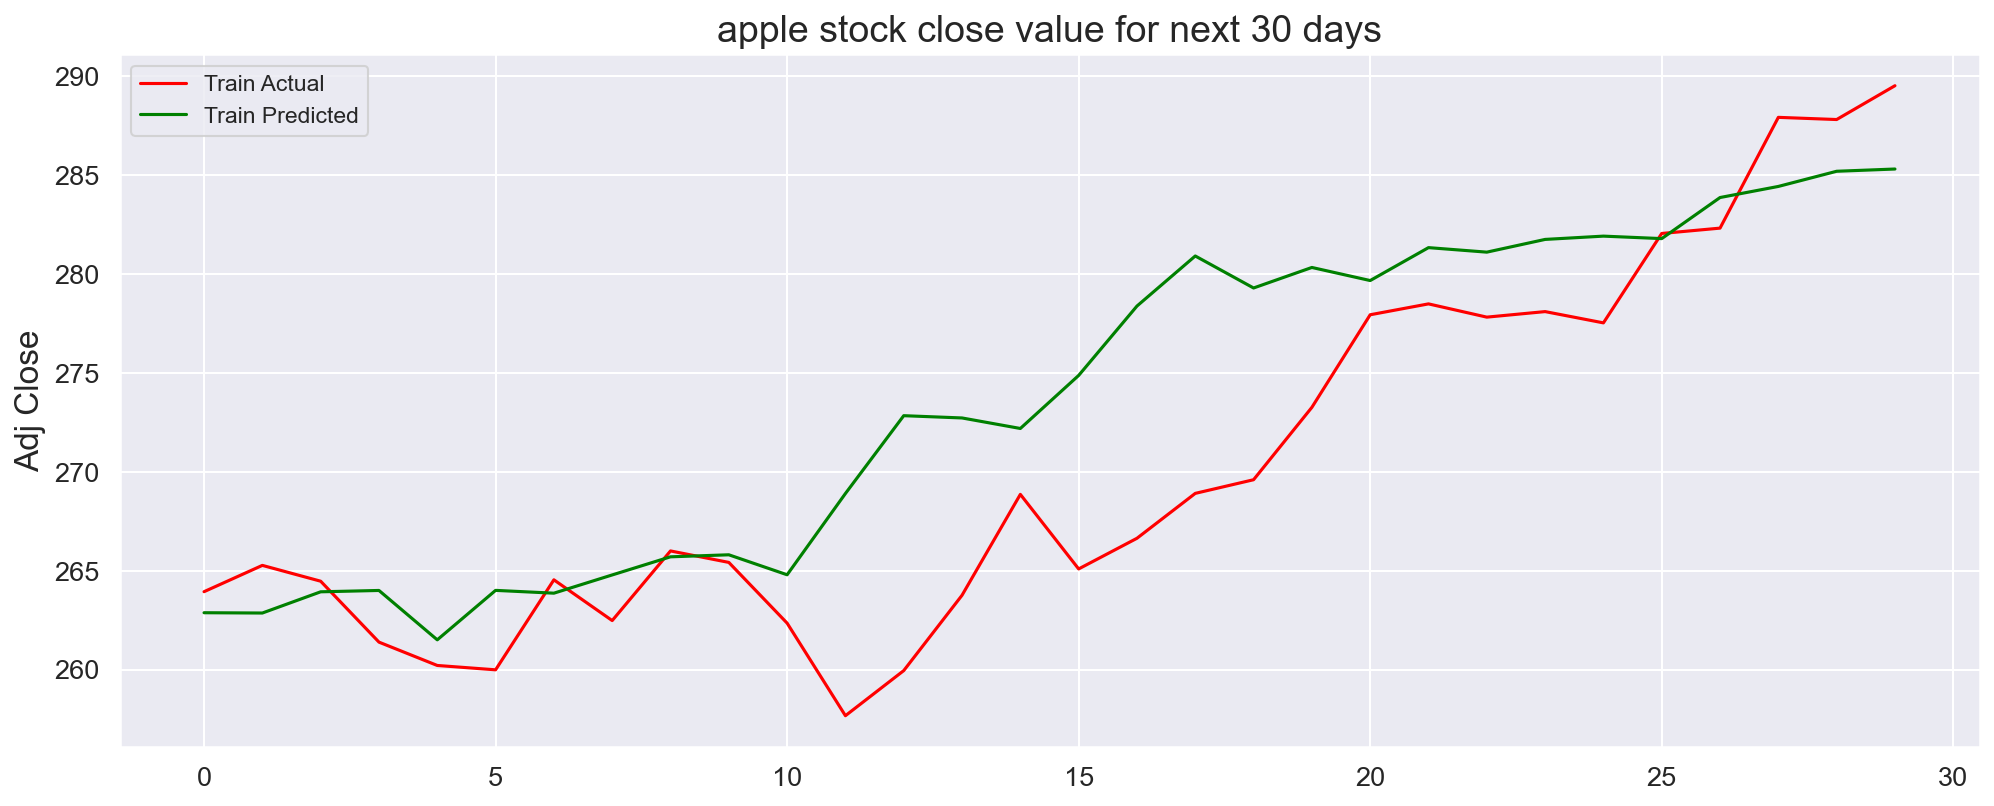

In [179]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Train Actual", color='red')
plt.plot(test.index, spred21021021_tst, label="Train Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

In [181]:
sarima11011063 = SARIMAX(train['Adj Close'], 
                 order=(1,1,0),
                seasonal_order=(1,1,0,63)).fit()
spred11011063_trn = sarima11011063.predict(start = train.index[0],end = train.index[-1])
spred11011063_tst = sarima11011063.predict(start = train.index[-1]+1,end = train.index[-1]+30)

In [182]:
sarima11011063.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1980
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 63)   Log Likelihood               -4431.716
Date:                            Wed, 31 May 2023   AIC                           8869.433
Time:                                    12:41:53   BIC                           8886.107
Sample:                                         0   HQIC                          8875.568
                                           - 1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0030      0.016      0.190      0.849      -0.028       0.034
ar.S.L63      -0.5011      0.013    -38.997      0.000      -0.526      -0.476
sigma2         5.9217      0.100     59.150      0.000       5.725       6.118
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2325.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.23   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [221]:
SA11011063_rmse_tr = mean_squared_error(train["Adj Close"], spred11011063_trn)**0.5
print('Train RMSE: %.3f' % SA11011063_rmse_tr)
SA11011063_rmse_ts = mean_squared_error(test["Adj Close"], spred11011063_tst)**0.5
print('Test RMSE: %.3f' % SA11011063_rmse_ts)

Train RMSE: 2.728
Test RMSE: 7.586


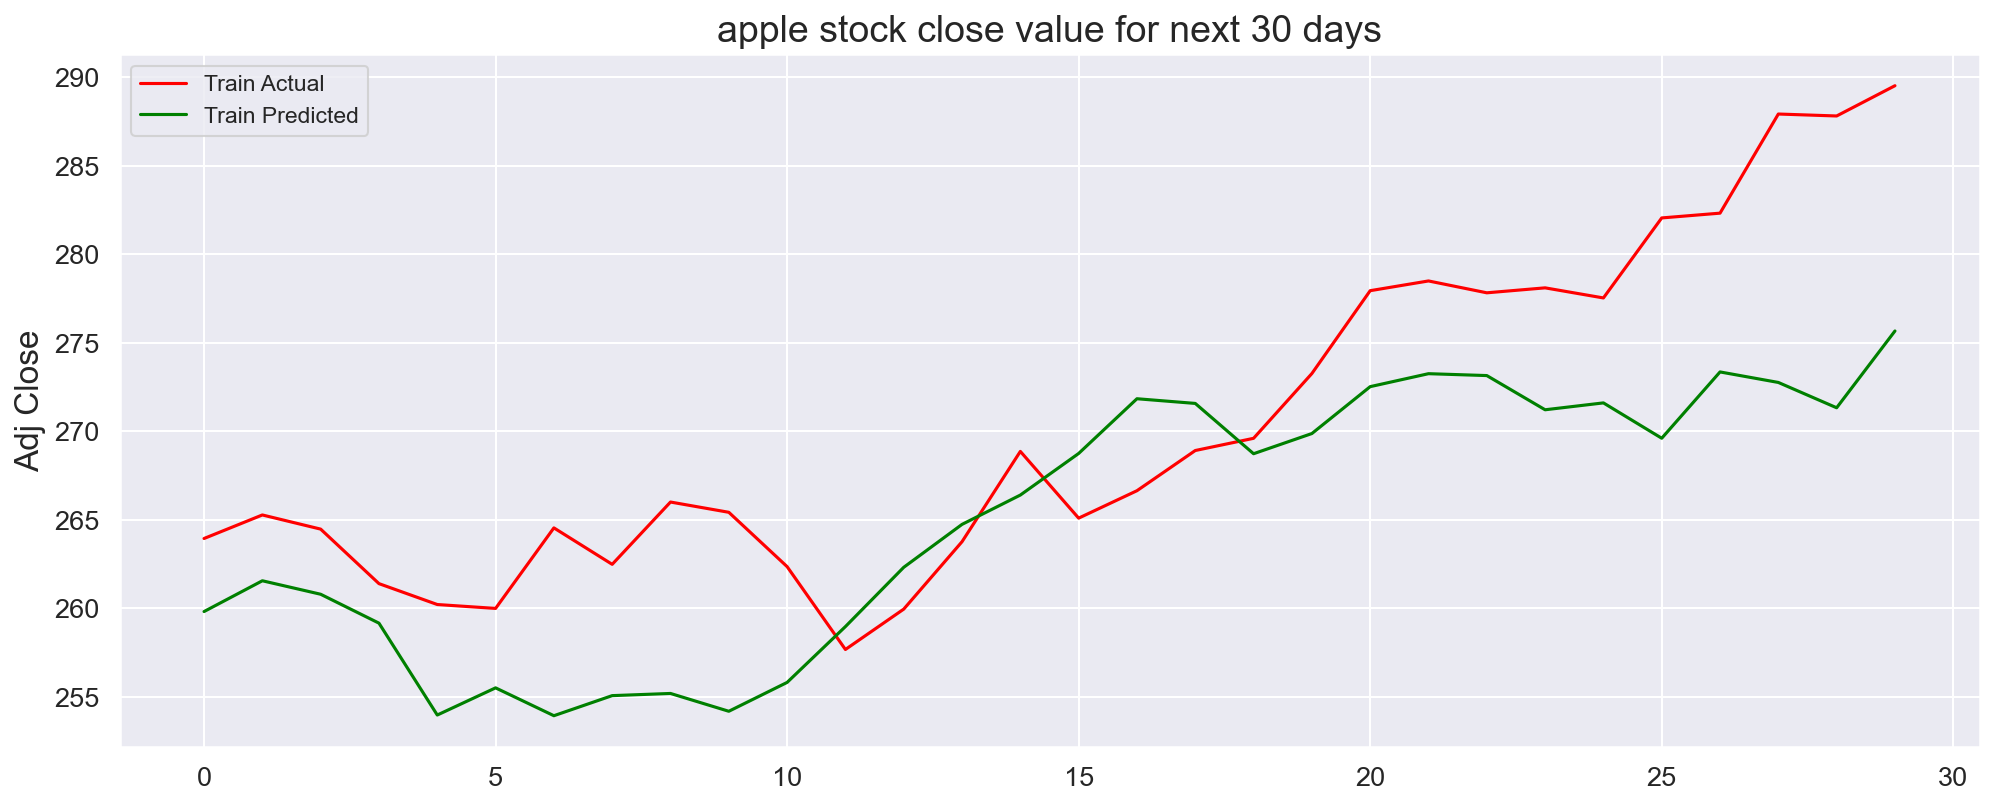

In [184]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Train Actual", color='red')
plt.plot(test.index, spred11011063_tst, label="Train Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

In [185]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima21011063 = SARIMAX(train['Adj Close'], 
                 order=(2,1,0),
                seasonal_order=(1,1,0,63)).fit()
spred21011063_trn = sarima21011063.predict(start = train.index[0], end = train.index[-1])
spred21011063_tst = sarima21011063.predict(start = train.index[-1]+1, end = train.index[-1]+30)

In [186]:
sarima21011063.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1980
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 63)   Log Likelihood               -4425.811
Date:                            Wed, 31 May 2023   AIC                           8859.623
Time:                                    12:45:00   BIC                           8881.855
Sample:                                         0   HQIC                          8867.804
                                           - 1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.016      0.206      0.837      -0.028       0.034
ar.L2         -0.0785      0.017     -4.583      0.000      -0.112      -0.045
ar.S.L63      -0.5045      0.013    -39.572      0.000      -0.529      -0.479
sigma2         5.8844      0.099     59.324      0.000       5.690       6.079
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2371.46
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.22   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
SA21011063_rmse_tr = mean_squared_error(train['Adj Close'], spred21011063_trn)**0.5
print('Train RMSE: %.3f' % SA21011063_rmse_tr)
SA21011063_rmse_ts = mean_squared_error(test['Adj Close'], spred21011063_tst)**0.5
print('Test RMSE: %.3f' % SA21011063_rmse_ts)

Train RMSE: 2.721
Test RMSE: 7.597


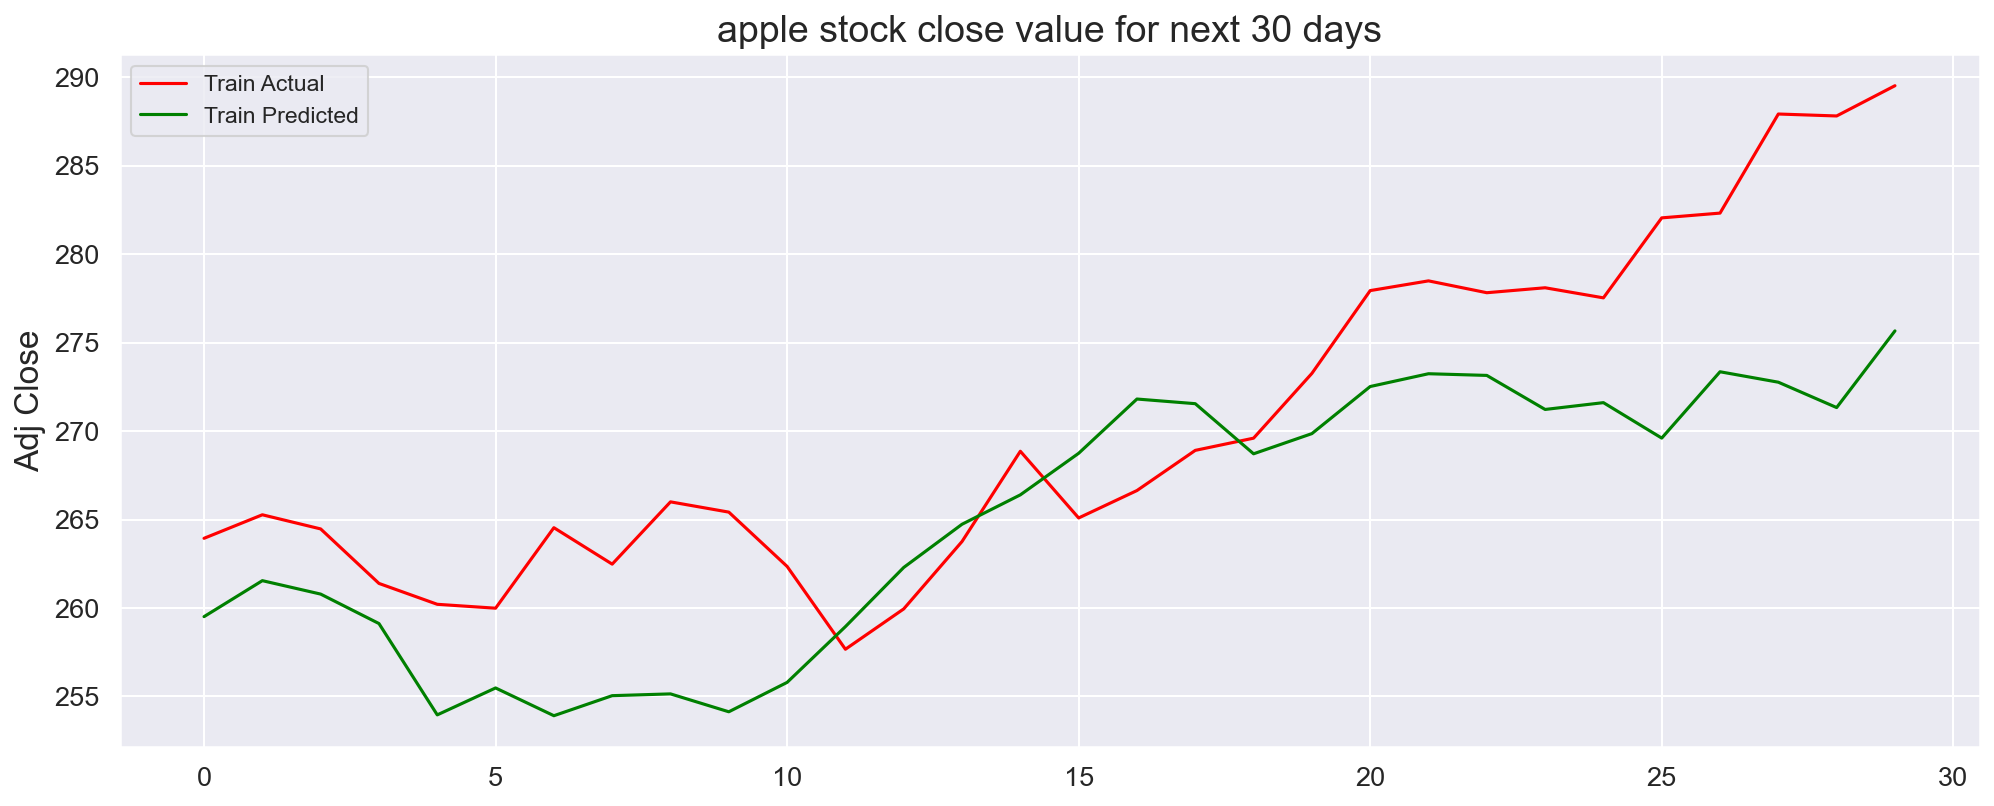

In [189]:
plt.figure(figsize=(16,6))
plt.plot(test.index, test['Adj Close'], label="Train Actual", color='red')
plt.plot(test.index, spred21011063_tst, label="Train Predicted", color='green')
plt.title('apple stock close value for next 30 days', fontsize=18)
plt.ylabel('Adj Close', fontsize=16)
plt.legend()

# HOLT WINTER

In [87]:
# Split the data into training and testing sets
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

In [192]:
# Apply Holt-Winters exponential smoothing with additive seasonality
model_add = ExponentialSmoothing(train['Adj Close'], seasonal='add', seasonal_periods=252).fit()


In [196]:
# Apply Holt-Winters exponential smoothing with multiplicative seasonality
model_mult = ExponentialSmoothing(train['Adj Close'], seasonal='mul', seasonal_periods=252).fit()

In [197]:
# Predict values using the trained models
preds_add = model_add.forecast(len(test['Adj Close']))
preds_mult = model_mult.forecast(len(test['Adj Close']))

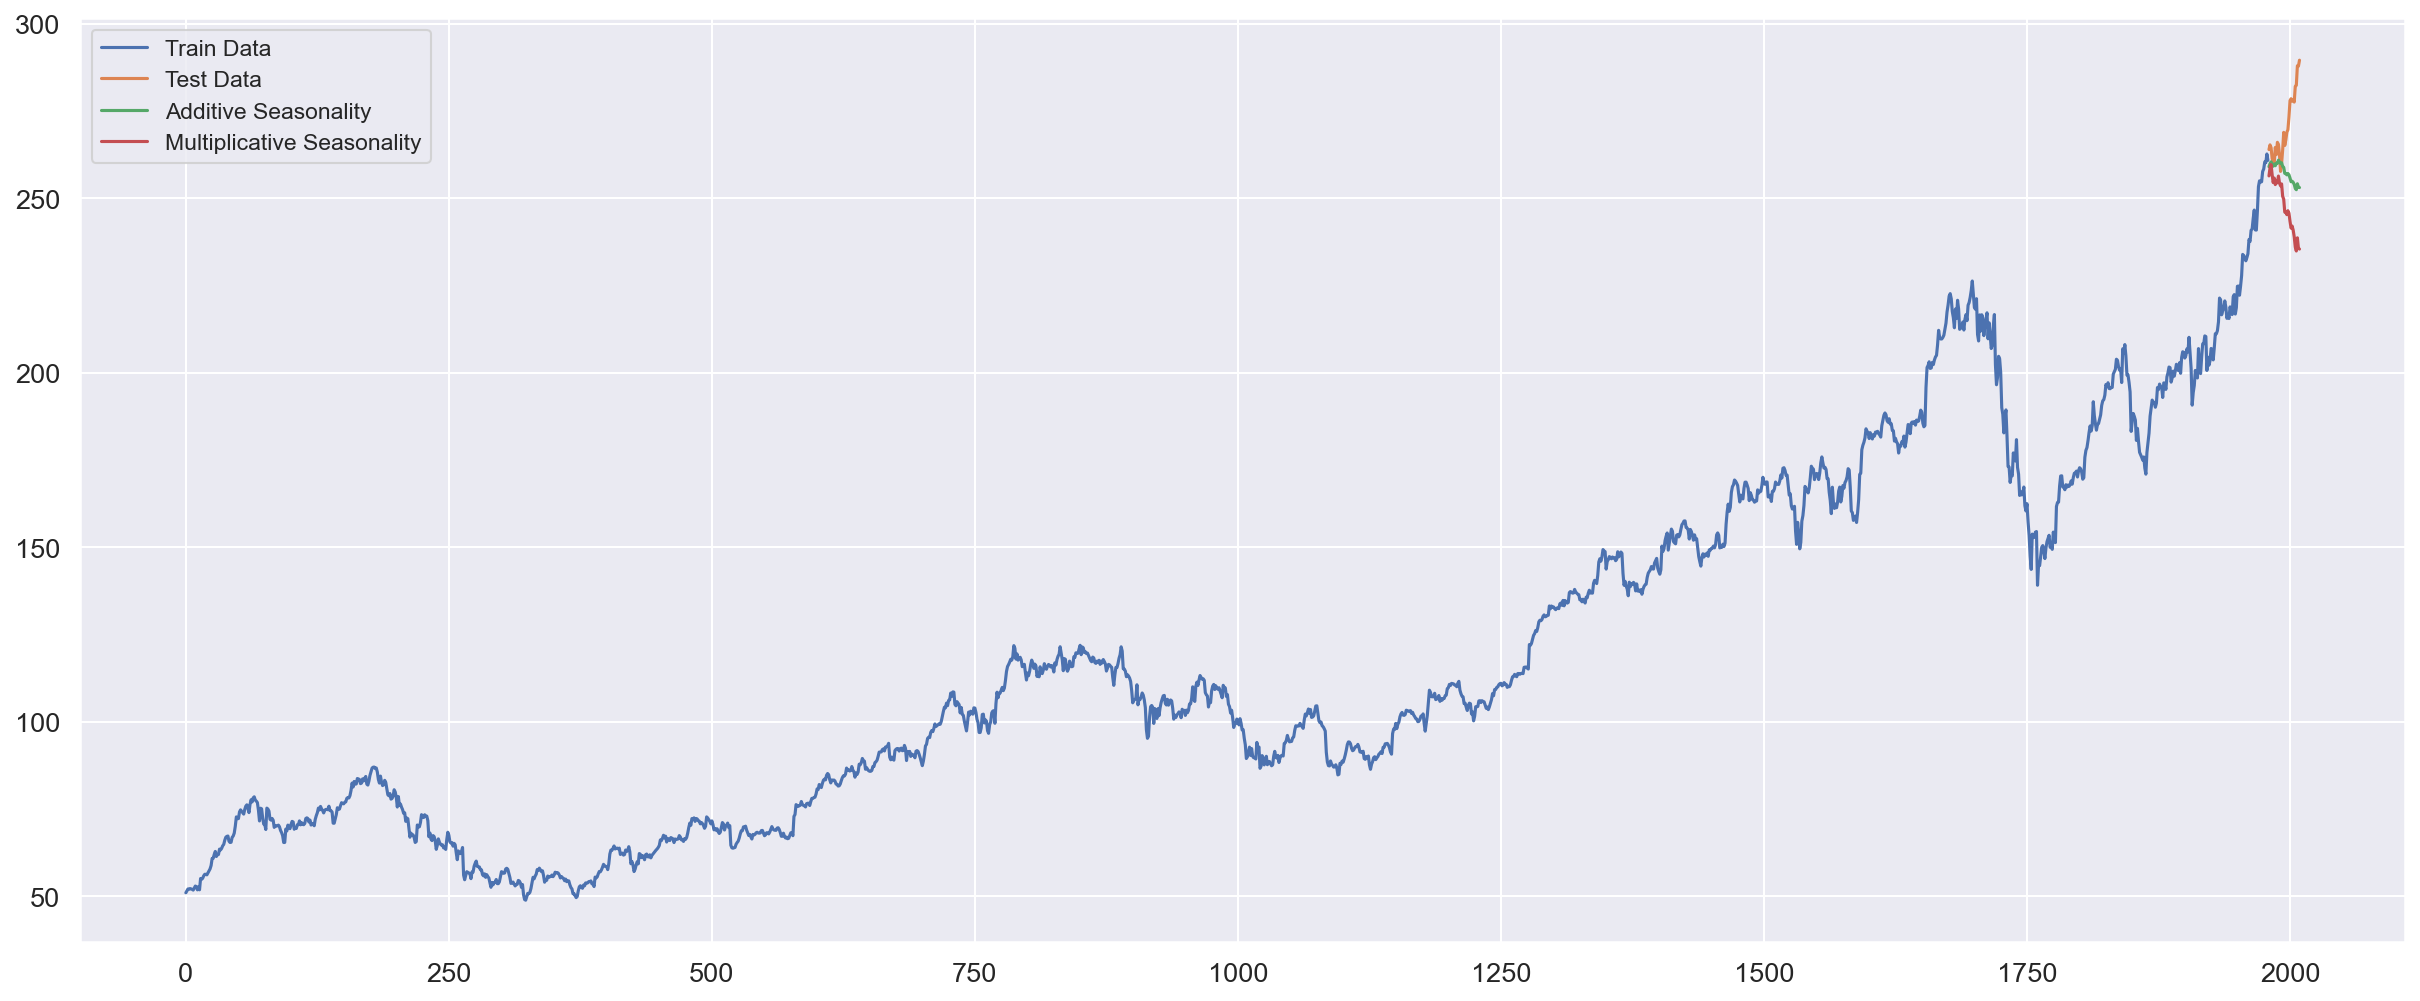

In [203]:
# Plot the actual and predicted values
plt.plot(train['Adj Close'], label='Train Data')
plt.plot(preds_add.index, test['Adj Close'], label='Test Data')
plt.plot(preds_add.index, preds_add, label='Additive Seasonality')
plt.plot(preds_mult.index, preds_mult, label='Multiplicative Seasonality')
plt.legend()
plt.show()

In [223]:
# Calculate RMSE for additive seasonality model
rmse_add = mean_squared_error(test['Adj Close'], preds_add)**0.5
print('RMSE for additive seasonality model:', rmse_add)

RMSE for additive seasonality model: 17.466324845378224


In [225]:
# Calculate RMSE for additive seasonality model
rmse_mult = mean_squared_error(test['Adj Close'], preds_mult)**0.5
print('RMSE for additive seasonality model:', rmse_mult)

RMSE for additive seasonality model: 27.721788999029258


In [236]:
metrics = pd.DataFrame({'Test RMSE': [A111_rmse_ts, A221_rmse_ts, A717_rmse_ts, A718_rmse_ts, A817_rmse_ts, A818_rmse_ts,
                                     SA11011021_rmse_ts, SA11011063_rmse_ts, SA21011021_rmse_ts, SA21011063_rmse_ts, 
                                     SA21021021_rmse_ts, rmse_add, rmse_mult],
                        'Train RMSE': [A111_rmse_tr, A221_rmse_tr, A717_rmse_tr, A718_rmse_tr, A817_rmse_tr, A818_rmse_tr,
                                      SA11011021_rmse_tr, SA11011063_rmse_tr, SA21011021_rmse_tr, SA21011063_rmse_tr, 
                                     SA21021021_rmse_tr, np.nan, np.nan]}, 
                       index=['ARIMA (1, 1, 1)', 'ARIMA (2, 2, 1)', 'ARIMA (7, 1, 7)', 'ARIMA (7, 1, 8)', 'ARIMA (8, 1, 7)', 'ARIMA (8, 1, 8)', 
                              'SARIMA (1, 1, 0)(1, 1, 0, 21)', 'SARIMA (1, 1, 0)(1, 1, 0, 63)', 'SARIMA (2, 1, 0)(1, 1, 0, 21)', 'SARIMA (2, 1, 0)(1, 1, 0, 63)',
                             'SARIMA (2, 1, 0)(2, 1, 0, 21)', 'Holt Winters Exp Smoothing(Additive)', 'Holt Winters Exp Smoothing(Multiplicative)'])
metrics = metrics.sort_values(by='Test RMSE').round(decimals=4)
metrics

Test RMSE  Train RMSE
SARIMA (2, 1, 0)(2, 1, 0, 21)                  5.8956      2.6046
SARIMA (1, 1, 0)(1, 1, 0, 63)                  7.5862      2.7279
SARIMA (2, 1, 0)(1, 1, 0, 63)                  7.5966      2.7213
SARIMA (2, 1, 0)(1, 1, 0, 21)                  7.6111      2.7223
SARIMA (1, 1, 0)(1, 1, 0, 21)                  7.6157      2.7270
ARIMA (7, 1, 7)                                9.4596      2.2985
ARIMA (8, 1, 7)                                9.9919      2.2966
ARIMA (8, 1, 8)                               10.2062      2.2967
ARIMA (7, 1, 8)                               10.4195      2.2987
ARIMA (2, 2, 1)                               13.2158      2.3174
ARIMA (1, 1, 1)                               13.2384      2.3183
Holt Winters Exp Smoothing(Additive)          17.4663         NaN
Holt Winters Exp Smoothing(Multiplicative)    27.7218         NaN

#### We can see that `SARIMA (2, 1, 0)(2, 1, 0, 21)` gives us the least `RMSE` value so we will be using that model for final deployment